In [ ]:
import pandas as pd

# Load the dataset into 'd'
d=pd.read_csv('dataset.csv')

# Show the first few rows of 'd'
d.head()


,f1,f2,f3,f4,f5,f6,f7,target
0,6,148,72,35,0,33.6,0.627,1
1,1,85,66,29,0,26.6,0.351,0
2,8,183,64,0,0,23.3,0.672,1
3,1,89,66,23,94,28.1,0.167,0
4,0,137,40,35,168,43.1,2.288,1


In [ ]:
# Get descriptive statistics for 'd' (summarizes central tendency, dispersion, etc.)
ds=d.describe()

# Count missing values in each column of 'd'
mv=d.isnull().sum()

ds, mv


(               f3      target
 count  766.000000  766.000000
 mean    69.118799    0.349869
 std     19.376901    0.477240
 min      0.000000    0.000000
 25%     62.500000    0.000000
 50%     72.000000    0.000000
 75%     80.000000    1.000000
 max    122.000000    1.000000,
 f1        0
 f2        0
 f3        0
 f4        0
 f5        0
 f6        0
 f7        0
 target    0
 dtype: int64)

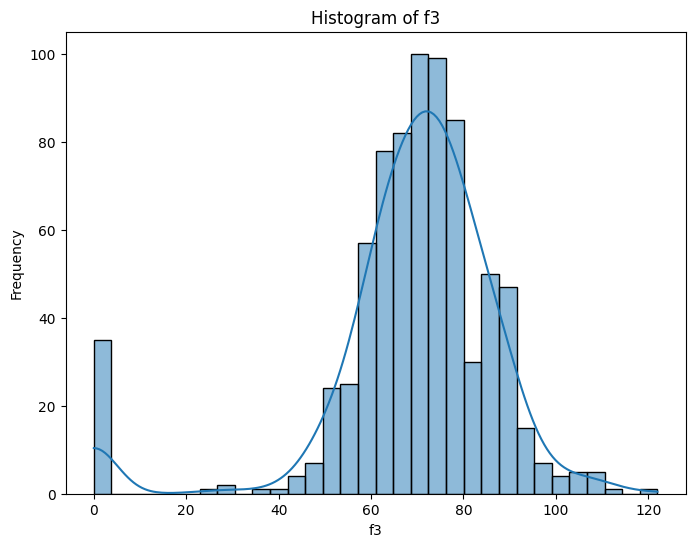

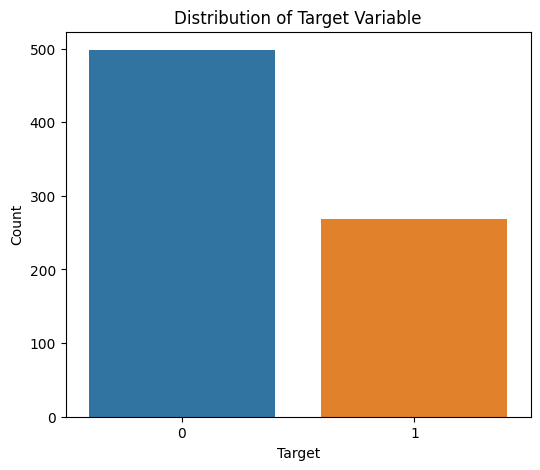

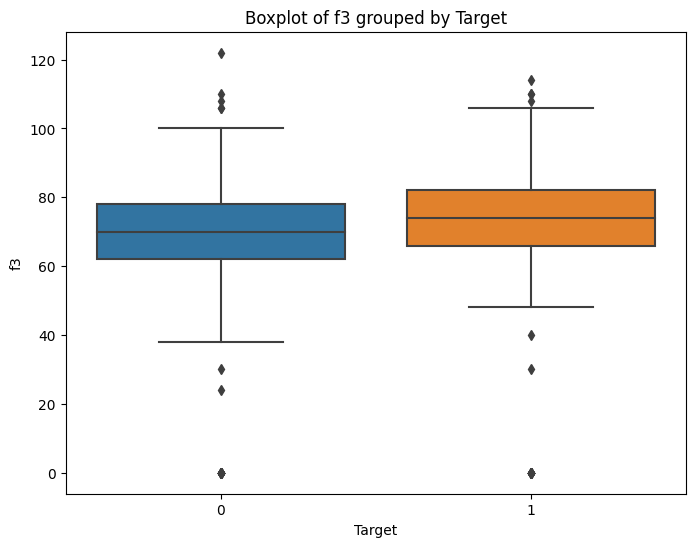

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram for 'f3' column
plt.figure(figsize=(8,6))
sns.histplot(d['f3'],kde=True)
plt.title('Histogram of f3')
plt.xlabel('f3')
plt.ylabel('Frequency')
plt.show()

# Plot bar chart for 'target' column
plt.figure(figsize=(6,5))
sns.countplot(x='target',data=d)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Boxplot for 'f3' grouped by 'target' column
plt.figure(figsize=(8,6))
sns.boxplot(x='target',y='f3',data=d)
plt.title('Boxplot of f3 grouped by Target')
plt.xlabel('Target')
plt.ylabel('f3')
plt.show()


In [ ]:
# Get data types of columns in 'd'
dt=d.dtypes

# Check for string entries in 'd'
str_count=d.applymap(lambda x: isinstance(x, str)).sum()

dt, str_count


(f1        object
 f2        object
 f3         int64
 f4        object
 f5        object
 f6        object
 f7        object
 target     int64
 dtype: object,
 f1        766
 f2        766
 f3          0
 f4        766
 f5        766
 f6        766
 f7        766
 target      0
 dtype: int64)

In [ ]:
# Convert columns in 'd' to numeric; set unconvertible values to NaN
dc=d.apply(pd.to_numeric,errors='coerce')

# Identify rows in 'dc' with NaN values that were originally non-numeric
nn_rows=dc[dc.isna().any(axis=1)]

nn_rows


,f1,f2,f3,f4,f5,f6,f7,target
760,9.0,NaN,74,31.0,0.0,44.0,0.403,1
761,9.0,89.0,62,0.0,0.0,22.5,NaN,0
762,10.0,101.0,76,48.0,180.0,NaN,0.171,0
763,2.0,122.0,70,27.0,NaN,36.8,0.340,0
764,NaN,121.0,72,23.0,112.0,26.2,0.245,0
765,1.0,126.0,60,NaN,0.0,30.1,0.349,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop rows with NaN values in 'dc' (originally non-numeric)
dc=dc.dropna()

# Check if any non-numeric entries remain in 'dc'
ri=dc.applymap(lambda x: isinstance(x, str)).sum()

# If no non-numeric entries, proceed with scaling and splitting
if ri.sum()==0:
    # Separate features and target variable from 'dc'
    Xc=dc.drop('target',axis=1)
    yc=dc['target']

    # Scale features using StandardScaler
    s=StandardScaler()
    Xs=s.fit_transform(Xc)

    # Split data: 80% train, 10% val, 10% test
    Xt, Xtmp, yt, ytmp=train_test_split(Xs, yc,test_size=0.2, random_state=42)
    Xv, Xts, yv, yts=train_test_split(Xtmp, ytmp, test_size=0.5,random_state=42)

    # Store shapes of the datasets to confirm process
    r=(Xt.shape,Xv.shape,Xts.shape), (yt.shape, yv.shape,yts.shape)
else:
    r="Issues still exist in the dataset."

r

(((608, 7), (76, 7), (76, 7)), ((608,), (76,), (76,)))

In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
# Convert datasets to DataLoader instances

# Training set
Xt_t=torch.Tensor(Xt)  # Convert training features to torch tensor
yt_t=torch.Tensor(yt.values).unsqueeze(1)  # Convert training targets to torch tensor & add dimension
train_ds=TensorDataset(Xt_t, yt_t)
train_dl=DataLoader(train_ds, batch_size=16, shuffle=True)

# Testing set
Xts_t=torch.Tensor(Xts)  # Convert testing features to torch tensor
yts_t=torch.Tensor(yts.values).unsqueeze(1)  # Convert testing targets to torch tensor & add dimension
test_ds=TensorDataset(Xts_t, yts_t)
test_dl=DataLoader(test_ds, batch_size=1, shuffle=False)

# Validation set
Xv_t=torch.Tensor(Xv)  # Convert validation features to torch tensor
yv_t=torch.Tensor(yv.values).unsqueeze(1)  # Convert validation targets to torch tensor & add dimension
val_ds=TensorDataset(Xv_t, yv_t)
val_dl=DataLoader(val_ds, batch_size=16, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

# Define a simple binary classification neural network
class BC(nn.Module):
    def __init__(self, dp=0.25, hl_size=64, activation_function=F.relu):
        super(BC, self).__init__()
        self.l1=nn.Linear(7,hl_size)
        self.l2=nn.Linear(hl_size, 128)
        self.l3=nn.Linear(128, 1)
        self.dp=nn.Dropout(dp)
        self.activation_function=activation_function

    def forward(self, x):
        x=self.activation_function(self.l1(x))
        x=self.dp(x)
        x=self.activation_function(self.l2(x))
        x=self.dp(x)
        x=torch.sigmoid(self.l3(x))
        return x

# Instantiate the model
m=BC()
# Get model summary
from torchinfo import summary
ms=summary(m, input_size=(1, 7))
ms

# Define loss function & optimizer
loss_fn=nn.BCELoss()
opt=Adam(m.parameters(), lr=0.001)

In [ ]:
ms

Layer (type:depth-idx)                   Output Shape              Param #
BC                                       [1, 1]                    --
├─Linear: 1-1                            [1, 64]                   512
├─Dropout: 1-2                           [1, 64]                   --
├─Linear: 1-3                            [1, 128]                  8,320
├─Dropout: 1-4                           [1, 128]                  --
├─Linear: 1-5                            [1, 1]                    129
Total params: 8,961
Trainable params: 8,961
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04

Epoch 1/25, T_L: 0.6313164767466093, V_L: 0.5203011870384217, Te_L: 0.6183736775756666, T_A: 65.78947368421052, V_A: 73.6842105263158, Te_A: 67.10526315789474
Epoch 2/25, T_L: 0.5432474668088713, V_L: 0.45524269342422485, Te_L: 0.5792294461525193, T_A: 73.6842105263158, V_A: 76.3157894736842, Te_A: 69.73684210526315
Epoch 3/25, T_L: 0.48775155763877065, V_L: 0.45327972173690795, Te_L: 0.5642597665489455, T_A: 76.3157894736842, V_A: 76.3157894736842, Te_A: 75.0
Epoch 4/25, T_L: 0.4817296509679995, V_L: 0.45445172786712645, Te_L: 0.5605285394045304, T_A: 75.65789473684211, V_A: 76.3157894736842, Te_A: 76.31578947368422
Epoch 5/25, T_L: 0.4719578019882503, V_L: 0.45966572761535646, Te_L: 0.5526610228377027, T_A: 77.96052631578948, V_A: 76.3157894736842, Te_A: 75.0
Epoch 6/25, T_L: 0.4589482185087706, V_L: 0.46781930327415466, Te_L: 0.5557680833567007, T_A: 79.27631578947368, V_A: 76.3157894736842, Te_A: 75.0
Epoch 7/25, T_L: 0.47087529929060684, V_L: 0.4802566319704056, Te_L: 0.5547512746

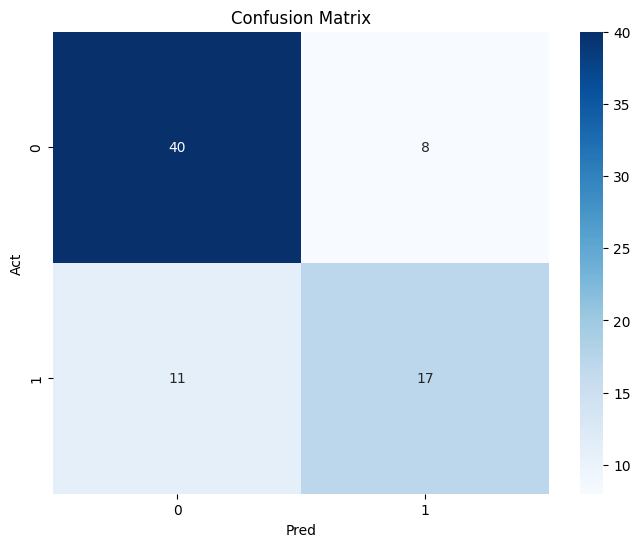

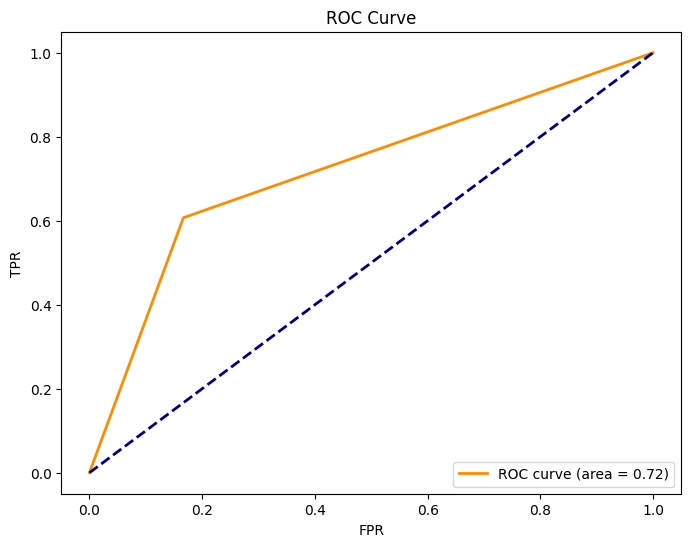

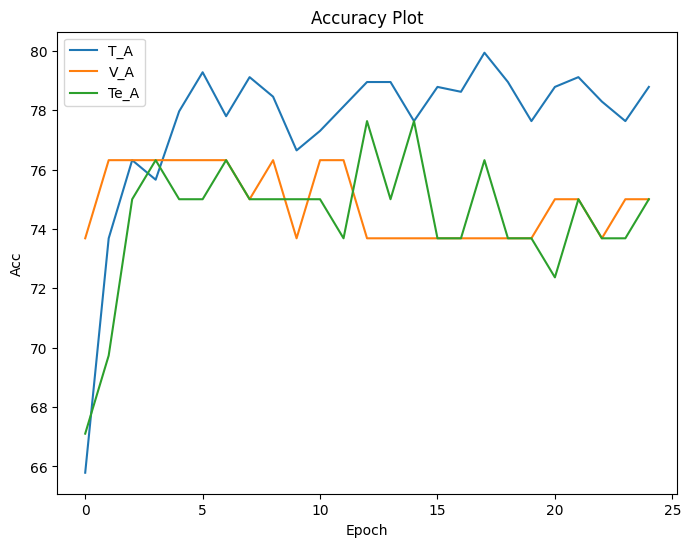

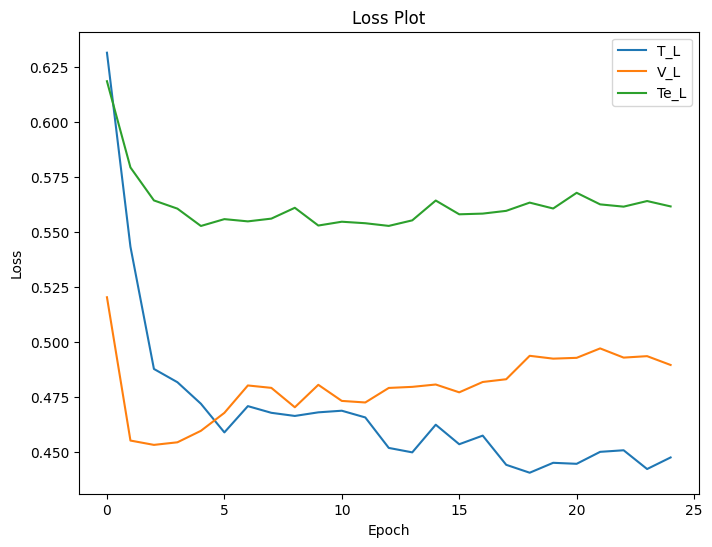

In [ ]:
# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import seaborn as sns
import time

# Training Loop with Validation and Test Loss
n_e=25
t_l, v_l, te_l, t_a, v_a, te_a=[], [], [], [], [], []
start_t=time.time()

for e in range(n_e):
    e_start_t=time.time()
    m.train()
    b_l=[]
    c_t, t_t=0, 0

    for i, l in train_dl:
        opt.zero_grad()
        o=m(i)
        loss=loss_fn(o, l)
        loss.backward()
        opt.step()
        b_l.append(loss.item())

        # Accuracy
        pred=torch.round(o)
        t_t+=l.numel()
        c_t+=int((pred == l).sum())

    t_l.append(np.mean(b_l))
    t_a.append(100 * c_t / t_t)

    # Validation
    m.eval()
    b_v_l=[]
    c_v, t_v=0, 0
    for i, l in val_dl:
        with torch.no_grad():
            o=m(i)
            v_l_=loss_fn(o, l)
            b_v_l.append(v_l_.item())

            # Accuracy
            pred=torch.round(o)
            t_v+=l.numel()
            c_v+=int((pred == l).sum())

    v_l.append(np.mean(b_v_l))
    v_a.append(100 * c_v / t_v)

    # Test
    b_te_l, pred_e, act_e=[], [], []
    for i, l in test_dl:
        with torch.no_grad():
            o=m(i)
            te_l_=loss_fn(o, l)
            b_te_l.append(te_l_.item())

            pred_val_e=torch.round(o)
            pred_e.extend(pred_val_e.numpy())
            act_e.extend(l.numpy())

    te_l.append(np.mean(b_te_l))
    te_a_e=accuracy_score(act_e, pred_e)
    te_a.append(te_a_e * 100)

    e_end_t=time.time()
    e_d=e_end_t - e_start_t
    print(f'Epoch {e+1}/{n_e}, T_L: {t_l[-1]}, V_L: {v_l[-1]}, Te_L: {te_l[-1]}, T_A: {t_a[-1]}, V_A: {v_a[-1]}, Te_A: {te_a[-1]}')

end_t=time.time()
tot_t=end_t - start_t
print(f'Total time: {tot_t:.2f}s ({tot_t/60:.2f}m)')

# Post-training eval
m.eval()
preds, acts=[], []
with torch.no_grad():
    for i, l in test_dl:
        o=m(i)
        preds_val=torch.round(o)
        preds.extend(preds_val.numpy())
        acts.extend(l.numpy())

acc = accuracy_score(acts, preds)
pr, re, f1, _=precision_recall_fscore_support(acts,preds,average='binary')
print(f'Acc: {acc}, Pr: {pr}, Re: {re}, F1: {f1}')

# Confusion Matrix
cfm=confusion_matrix(acts, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Act')
plt.xlabel('Pred')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _=roc_curve(acts, preds)
roc_auc=auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange',lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2,linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Accuracy plots
e_range=range(n_e)
plt.figure(figsize=(8, 6))
plt.plot(e_range, t_a, label='T_A')
plt.plot(e_range, v_a, label='V_A')
plt.plot(e_range, te_a, label='Te_A')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_l,label='T_L')
plt.plot(e_range,v_l,label='V_L')
plt.plot(e_range,te_l,label='Te_L')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

In [ ]:
# Save model
torch.save(m.state_dict(), 'm.pth')

Part 2

setup 1 - **dp=0.2**, hl_size=64, **activation_function=F.relu**, **opt = Adam**

Epoch 1/25, T_L: 0.6351567538161027, V_L: 0.5463122546672821, Te_L: 0.6039325308642889, T_A: 68.91447368421052, V_A: 77.63157894736842, Te_A: 68.42105263157895
Epoch 2/25, T_L: 0.5138216951960012, V_L: 0.47695552706718447, Te_L: 0.566423845918555, T_A: 76.15131578947368, V_A: 76.3157894736842, Te_A: 76.31578947368422
Epoch 3/25, T_L: 0.4909058275975679, V_L: 0.4584090918302536, Te_L: 0.5624293072737361, T_A: 76.64473684210526, V_A: 73.6842105263158, Te_A: 72.36842105263158
Epoch 4/25, T_L: 0.46503722746121257, V_L: 0.4645159214735031, Te_L: 0.5592906082196063, T_A: 77.79605263157895, V_A: 76.3157894736842, Te_A: 72.36842105263158
Epoch 5/25, T_L: 0.46217681702814606, V_L: 0.470840847492218, Te_L: 0.5615442540698783, T_A: 77.13815789473684, V_A: 73.6842105263158, Te_A: 75.0
Epoch 6/25, T_L: 0.4653635436767026, V_L: 0.46591676473617555, Te_L: 0.5520656030704757, T_A: 77.13815789473684, V_A: 76.3157894736842, Te_A: 75.0
Epoch 7/25, T_L: 0.4596444391890576, V_L: 0.47435704469680784, Te_L: 

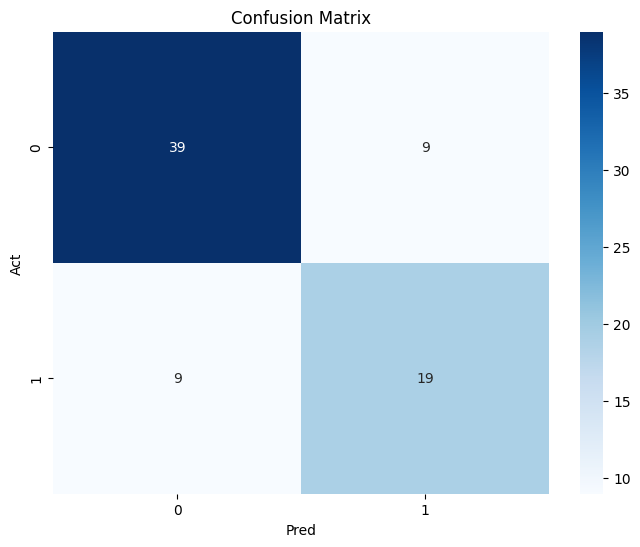

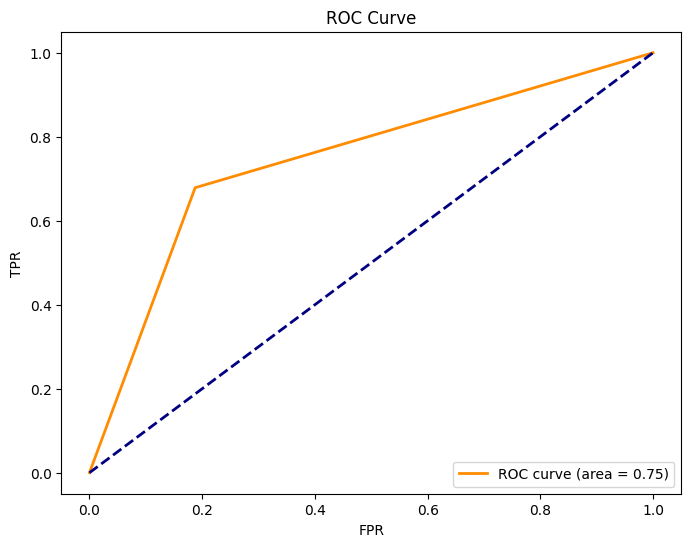

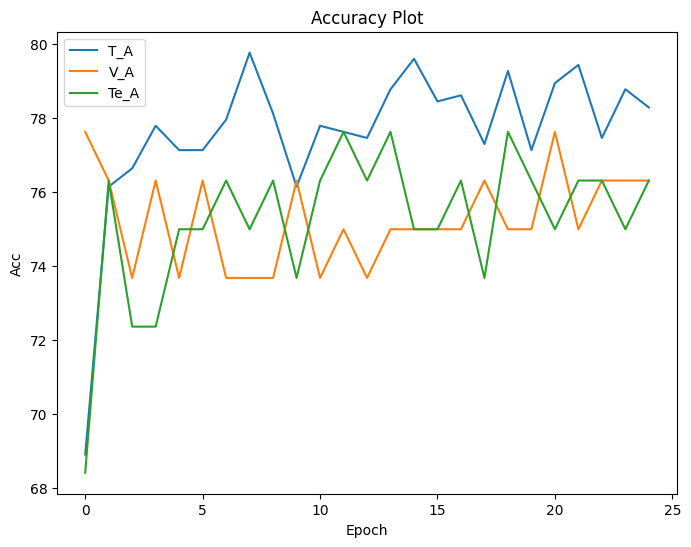

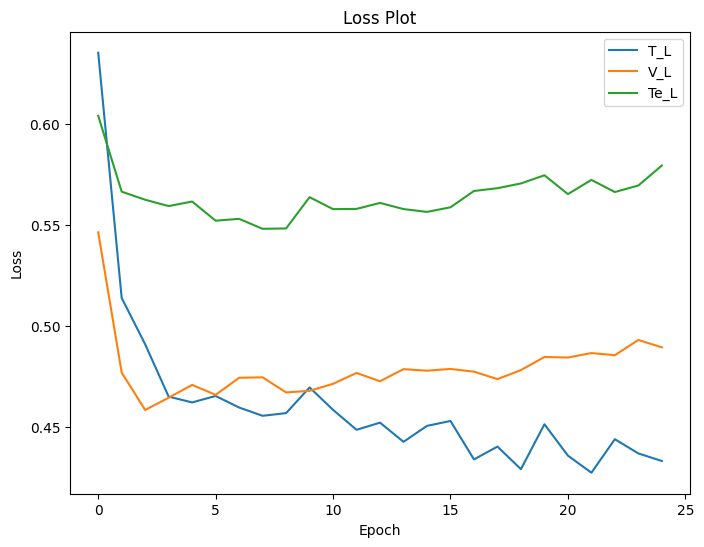

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time


class BC1(nn.Module):
    def __init__(self, dp=0.25, hl_size=64, activation_function=F.relu):
        super(BC1, self).__init__() # Corrected the class name here from BC to BC1
        self.l1=nn.Linear(7,hl_size)
        self.l2=nn.Linear(hl_size,128)
        self.l3=nn.Linear(128,1)
        self.dp=nn.Dropout(dp)
        self.activation_function=activation_function

    def forward(self, x):
        x=self.activation_function(self.l1(x))
        x=self.dp(x)
        x=self.activation_function(self.l2(x))
        x=self.dp(x)
        x=torch.sigmoid(self.l3(x))
        return x

# Instantiate the model
m1=BC1(dp=0.2, hl_size=64, activation_function=F.relu)
# Get model summary
from torchinfo import summary
ms=summary(m1, input_size=(1, 7))
ms

# Define loss function & optimizer
loss_fn=nn.BCELoss()
opt=Adam(m1.parameters(), lr=0.001)

# Training Loop with Validation and Test Loss
n_e=25
t_l1, v_l1, te_l1, t_a1, v_a1, te_a1 = [], [], [], [], [], []
start_t=time.time()

for e in range(n_e):
    e_start_t=time.time()
    m1.train()
    b_l=[]
    c_t, t_t=0, 0

    for i, l in train_dl:
        opt.zero_grad()
        o=m1(i)
        loss=loss_fn(o, l)
        loss.backward()
        opt.step()
        b_l.append(loss.item())

        # Accuracy
        pred=torch.round(o)
        t_t+=l.numel()
        c_t+=int((pred==l).sum())

    t_l1.append(np.mean(b_l))
    t_a1.append(100 * c_t / t_t)

    # Validation
    m1.eval()
    b_v_l=[]
    c_v, t_v=0, 0
    for i, l in val_dl:
        with torch.no_grad():
            o=m1(i)
            v_l_=loss_fn(o, l)
            b_v_l.append(v_l_.item())

            # Accuracy
            pred=torch.round(o)
            t_v+=l.numel()
            c_v+=int((pred==l).sum())

    v_l1.append(np.mean(b_v_l))
    v_a1.append(100 * c_v / t_v)

    # Test
    b_te_l, pred_e, act_e=[], [], []
    for i, l in test_dl:
        with torch.no_grad():
            o=m1(i)
            te_l_=loss_fn(o, l)
            b_te_l.append(te_l_.item())

            pred_val_e=torch.round(o)
            pred_e.extend(pred_val_e.numpy())
            act_e.extend(l.numpy())

    te_l1.append(np.mean(b_te_l))
    te_a_e=accuracy_score(act_e, pred_e)
    te_a1.append(te_a_e * 100)

    e_end_t=time.time()
    e_d=e_end_t - e_start_t
    print(f'Epoch {e+1}/{n_e}, T_L: {t_l1[-1]}, V_L: {v_l1[-1]}, Te_L: {te_l1[-1]}, T_A: {t_a1[-1]}, V_A: {v_a1[-1]}, Te_A: {te_a1[-1]}')

end_t=time.time()
tot_t=end_t - start_t
print(f'Total time: {tot_t:.2f}s ({tot_t/60:.2f}m)')

# Post-training eval
m1.eval()
preds, acts=[], []
with torch.no_grad():
    for i, l in test_dl:
        o=m1(i)
        preds_val=torch.round(o)
        preds.extend(preds_val.numpy())
        acts.extend(l.numpy())

acc=accuracy_score(acts, preds)
pr, re, f1, _=precision_recall_fscore_support(acts, preds, average='binary')
print(f'Acc: {acc}, Pr: {pr}, Re: {re}, F1: {f1}')

# Confusion Matrix
cfm = confusion_matrix(acts,preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Act')
plt.xlabel('Pred')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(acts, preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr,color='darkorange',lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1],[0, 1],color='navy',lw=2,linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Accuracy plots
e_range = range(n_e)
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_a1,label='T_A')
plt.plot(e_range,v_a1,label='V_A')
plt.plot(e_range,te_a1,label='Te_A')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(8, 6))
plt.plot(e_range, t_l1,label='T_L')
plt.plot(e_range,v_l1, label='V_L')
plt.plot(e_range, te_l1,label='Te_L')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()


In [ ]:
# Save model
torch.save(m1.state_dict(), 'm1.pth')


setup 2 - **dp=0.4**, hl_size=64, **activation_function=F.relu**, **opt = Adam**

Epoch 1/25, T_L2: 0.6309859987936521, V_L2: 0.5370539009571076, Te_L2: 0.6119042003625318, T_A2: 68.25657894736842, V_A2: 76.3157894736842, Te_A2: 71.05263157894737
Epoch 2/25, T_L2: 0.5429434462597496, V_L2: 0.4682904839515686, Te_L2: 0.5773719872446045, T_A2: 74.67105263157895, V_A2: 77.63157894736842, Te_A2: 73.68421052631578
Epoch 3/25, T_L2: 0.501161977648735, V_L2: 0.4498694211244583, Te_L2: 0.5703494260700321, T_A2: 75.65789473684211, V_A2: 76.3157894736842, Te_A2: 73.68421052631578
Epoch 4/25, T_L2: 0.49619212511338684, V_L2: 0.45913985669612883, Te_L2: 0.5659441374438373, T_A2: 76.48026315789474, V_A2: 75.0, Te_A2: 72.36842105263158
Epoch 5/25, T_L2: 0.47852029769044174, V_L2: 0.4533383399248123, Te_L2: 0.5611051586303418, T_A2: 77.63157894736842, V_A2: 76.3157894736842, Te_A2: 76.31578947368422
Epoch 6/25, T_L2: 0.48571876710967016, V_L2: 0.4594500184059143, Te_L2: 0.558991852234804, T_A2: 76.48026315789474, V_A2: 76.3157894736842, Te_A2: 72.36842105263158
Epoch 7/25, T_L2: 0

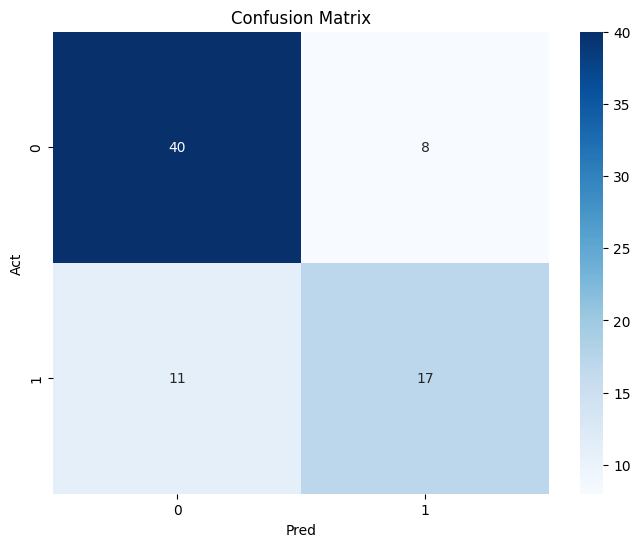

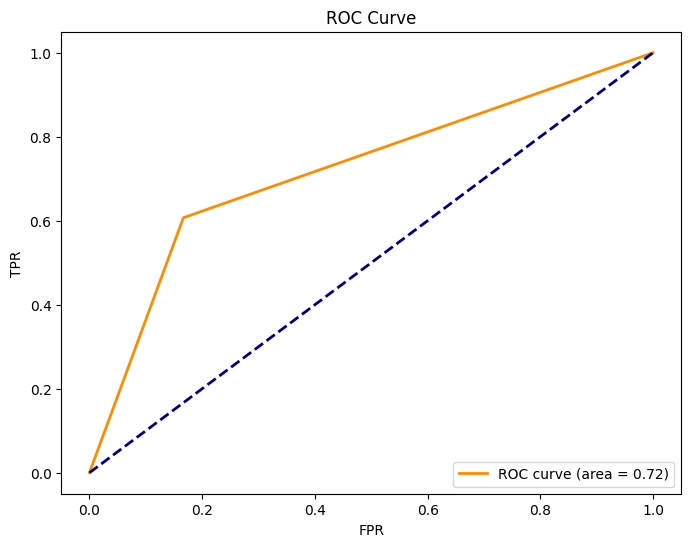

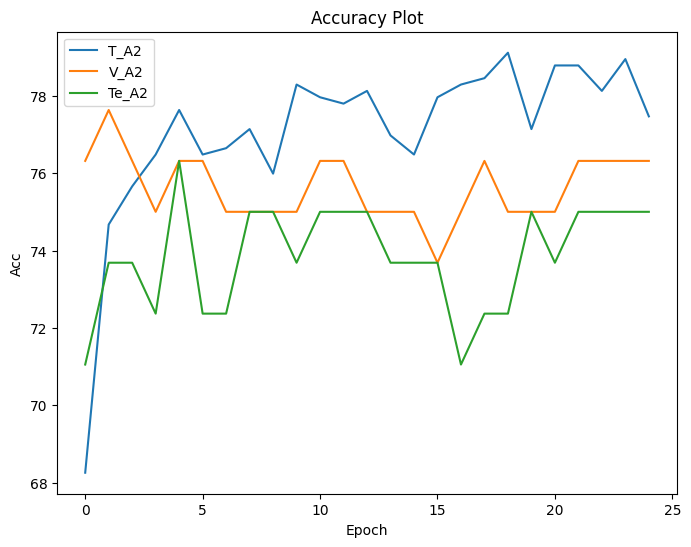

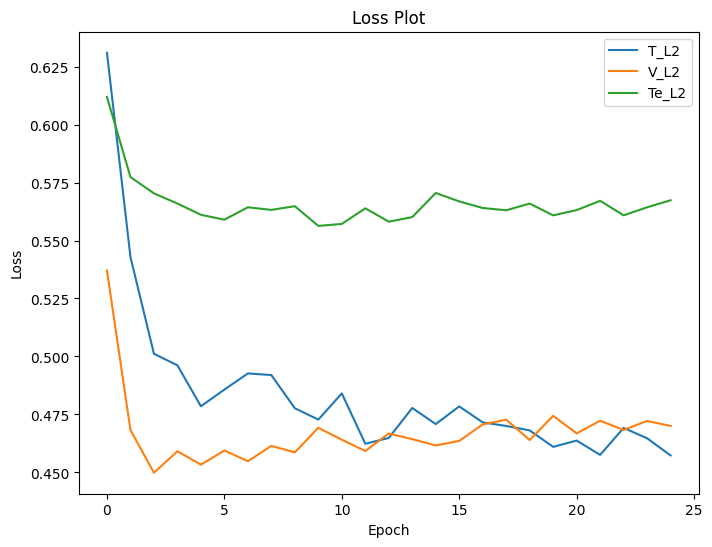

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time


class BC2(nn.Module):
    def __init__(self, dp=0.25, hl_size=64, activation_function=F.relu):
        super(BC2, self).__init__()
        self.l1=nn.Linear(7, hl_size)
        self.l2=nn.Linear(hl_size, 128)
        self.l3=nn.Linear(128, 1)
        self.dp=nn.Dropout(dp)
        self.activation_function=activation_function

    def forward(self, x):
        x=self.activation_function(self.l1(x))
        x=self.dp(x)
        x=self.activation_function(self.l2(x))
        x=self.dp(x)
        x=torch.sigmoid(self.l3(x))
        return x

# Instantiate the model
m2=BC2(dp=0.4, hl_size=64, activation_function=F.relu)
# Get model summary
from torchinfo import summary
ms=summary(m2, input_size=(1, 7))
ms

# Define loss function & optimizer
loss_fn=nn.BCELoss()
opt=Adam(m2.parameters(),lr=0.001)

# Training Loop with Validation and Test Loss
n_e=25
t_l2, v_l2, te_l2,t_a2,v_a2, te_a2 = [], [], [], [], [], []
start_t=time.time()

for e in range(n_e):
    e_start_t=time.time()
    m2.train()
    b_l=[]
    c_t, t_t=0, 0

    for i, l in train_dl:
        opt.zero_grad()
        o=m2(i)
        loss=loss_fn(o, l)
        loss.backward()
        opt.step()
        b_l.append(loss.item())

        # Accuracy
        pred=torch.round(o)
        t_t+=l.numel()
        c_t+=int((pred == l).sum())

    t_l2.append(np.mean(b_l))
    t_a2.append(100 * c_t / t_t)

    # Validation
    m2.eval()
    b_v_l=[]
    c_v, t_v=0, 0
    for i, l in val_dl:
        with torch.no_grad():
            o=m2(i)
            v_l_=loss_fn(o, l)
            b_v_l.append(v_l_.item())

            # Accuracy
            pred=torch.round(o)
            t_v+=l.numel()
            c_v+=int((pred==l).sum())

    v_l2.append(np.mean(b_v_l))
    v_a2.append(100 * c_v / t_v)

    # Test
    b_te_l, pred_e, act_e=[], [], []
    for i, l in test_dl:
        with torch.no_grad():
            o=m2(i)
            te_l_=loss_fn(o, l)
            b_te_l.append(te_l_.item())

            pred_val_e=torch.round(o)
            pred_e.extend(pred_val_e.numpy())
            act_e.extend(l.numpy())

    te_l2.append(np.mean(b_te_l))
    te_a_e=accuracy_score(act_e, pred_e)
    te_a2.append(te_a_e * 100)

    e_end_t=time.time()
    e_d=e_end_t-e_start_t
    print(f'Epoch {e+1}/{n_e}, T_L2: {t_l2[-1]}, V_L2: {v_l2[-1]}, Te_L2: {te_l2[-1]}, T_A2: {t_a2[-1]}, V_A2: {v_a2[-1]}, Te_A2: {te_a2[-1]}')

end_t=time.time()
tot_t=end_t-start_t
print(f'Total time: {tot_t:.2f}s ({tot_t/60:.2f}m)')

# Post-training eval
m2.eval()
preds, acts=[], []
with torch.no_grad():
    for i, l in test_dl:
        o=m2(i)
        preds_val=torch.round(o)
        preds.extend(preds_val.numpy())
        acts.extend(l.numpy())

acc=accuracy_score(acts, preds)
pr, re, f1, _=precision_recall_fscore_support(acts, preds, average='binary')
print(f'Acc: {acc}, Pr: {pr}, Re: {re}, F1: {f1}')

# Confusion Matrix
cfm=confusion_matrix(acts, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Act')
plt.xlabel('Pred')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _=roc_curve(acts, preds)
roc_auc=auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange',lw=2,label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1],color='navy',lw=2,linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Accuracy plots
e_range=range(n_e)
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_a2,label='T_A2')
plt.plot(e_range,v_a2,label='V_A2')
plt.plot(e_range,te_a2,label='Te_A2')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_l2,label='T_L2')
plt.plot(e_range,v_l2,label='V_L2')
plt.plot(e_range,te_l2,label='Te_L2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

In [ ]:
# Save model
torch.save(m2.state_dict(), 'm2.pth')

Setup 3 - **dp=0.6**, hl_size=64, **activation_function=F.relu**, **opt = Adam**

Epoch 1/25, T_L: 0.6498047552610698, V_L: 0.5646837890148163, Te_L: 0.6324716198601221, T_A: 63.651315789473685, V_A: 69.73684210526316, Te_A: 63.1578947368421
Epoch 2/25, T_L: 0.5968175161825983, V_L: 0.4986154556274414, Te_L: 0.5889161447749326, T_A: 70.72368421052632, V_A: 77.63157894736842, Te_A: 73.68421052631578
Epoch 3/25, T_L: 0.5575054162426999, V_L: 0.4600667178630829, Te_L: 0.5663552038052952, T_A: 72.03947368421052, V_A: 80.26315789473684, Te_A: 76.31578947368422
Epoch 4/25, T_L: 0.526143449701761, V_L: 0.4377292633056641, Te_L: 0.5573723769660941, T_A: 74.67105263157895, V_A: 78.94736842105263, Te_A: 73.68421052631578
Epoch 5/25, T_L: 0.5267498116744193, V_L: 0.4283865958452225, Te_L: 0.5562397599630793, T_A: 73.02631578947368, V_A: 77.63157894736842, Te_A: 75.0
Epoch 6/25, T_L: 0.49571148894335093, V_L: 0.4284828156232834, Te_L: 0.5631999877499, T_A: 77.63157894736842, V_A: 76.3157894736842, Te_A: 75.0
Epoch 7/25, T_L: 0.5087998023158625, V_L: 0.43731607496738434, Te_L: 0

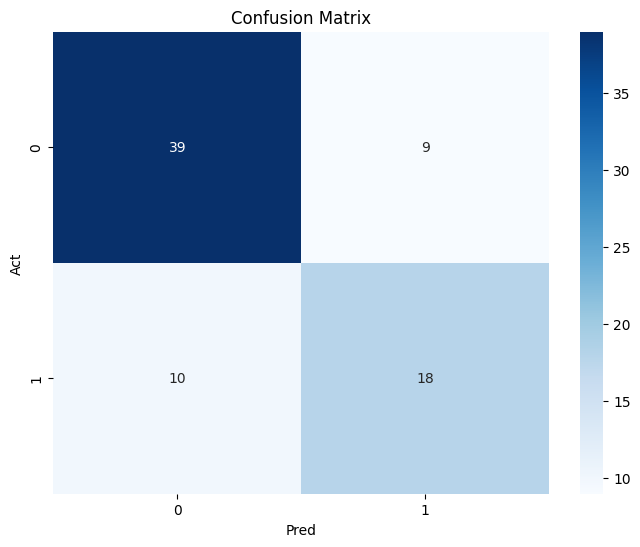

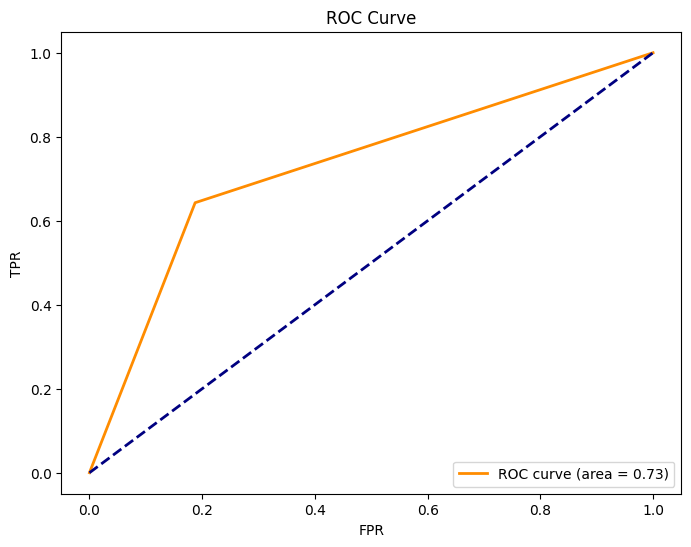

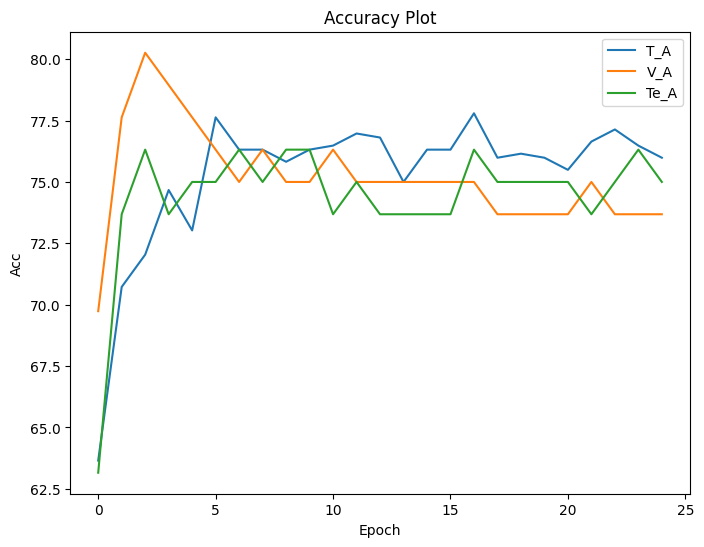

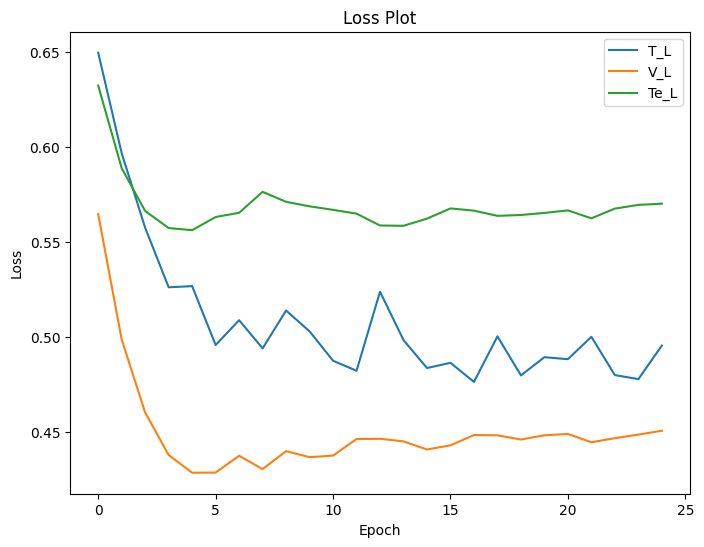

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time


class BC3(nn.Module):
    def __init__(self, dp=0.25, hl_size=64, activation_function=F.relu):
        super(BC3, self).__init__()
        self.l1=nn.Linear(7, hl_size)
        self.l2=nn.Linear(hl_size, 128)
        self.l3=nn.Linear(128, 1)
        self.dp=nn.Dropout(dp)
        self.activation_function=activation_function

    def forward(self, x):
        x=self.activation_function(self.l1(x))
        x=self.dp(x)
        x=self.activation_function(self.l2(x))
        x=self.dp(x)
        x=torch.sigmoid(self.l3(x))
        return x

# Instantiate the model
m3=BC3(dp=0.6, hl_size=64, activation_function=F.relu)
# Get model summary
from torchinfo import summary
ms=summary(m3, input_size=(1, 7))
ms

# Define loss function & optimizer
loss_fn=nn.BCELoss()
opt=Adam(m3.parameters(), lr=0.001)

# Imports (You have repeated imports here, so I suggest cleaning this up later.)
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import seaborn as sns
import time

# Training Loop with Validation and Test Loss
n_e=25
t_l3, v_l3, te_l3, t_a3, v_a3, te_a3 = [], [], [], [], [], []
start_t=time.time()

for e in range(n_e):
    e_start_t=time.time()
    m3.train()
    b_l=[]
    c_t, t_t=0, 0

    for i, l in train_dl:
        opt.zero_grad()
        o=m3(i)
        loss=loss_fn(o, l)
        loss.backward()
        opt.step()
        b_l.append(loss.item())

        # Accuracy
        pred=torch.round(o)
        t_t+=l.numel()
        c_t+=int((pred == l).sum())

    t_l3.append(np.mean(b_l))
    t_a3.append(100 * c_t / t_t)

    # Validation
    m3.eval()
    b_v_l=[]
    c_v, t_v=0, 0
    for i, l in val_dl:
        with torch.no_grad():
            o=m3(i)
            v_l_=loss_fn(o, l)
            b_v_l.append(v_l_.item())

            # Accuracy
            pred=torch.round(o)
            t_v+=l.numel()
            c_v+=int((pred == l).sum())

    v_l3.append(np.mean(b_v_l))
    v_a3.append(100 * c_v / t_v)

    # Test
    b_te_l, pred_e, act_e=[], [], []
    for i, l in test_dl:
        with torch.no_grad():
            o=m3(i)
            te_l_=loss_fn(o, l)
            b_te_l.append(te_l_.item())

            pred_val_e=torch.round(o)
            pred_e.extend(pred_val_e.numpy())
            act_e.extend(l.numpy())

    te_l3.append(np.mean(b_te_l))
    te_a_e=accuracy_score(act_e, pred_e)
    te_a3.append(te_a_e * 100)

    e_end_t=time.time()
    e_d=e_end_t-e_start_t
    print(f'Epoch {e+1}/{n_e}, T_L: {t_l3[-1]}, V_L: {v_l3[-1]}, Te_L: {te_l3[-1]}, T_A: {t_a3[-1]}, V_A: {v_a3[-1]}, Te_A: {te_a3[-1]}')

end_t=time.time()
tot_t=end_t-start_t
print(f'Total time: {tot_t:.2f}s ({tot_t/60:.2f}m)')

# Post-training eval
m3.eval()
preds,acts=[],[]
with torch.no_grad():
    for i, l in test_dl:
        o=m3(i)
        preds_val=torch.round(o)
        preds.extend(preds_val.numpy())
        acts.extend(l.numpy())

acc=accuracy_score(acts, preds)
pr, re, f1, _=precision_recall_fscore_support(acts, preds, average='binary')
print(f'Acc: {acc}, Pr: {pr}, Re: {re}, F1: {f1}')

# Confusion Matrix
cfm=confusion_matrix(acts,preds)
plt.figure(figsize=(8,6))
sns.heatmap(cfm,annot=True,fmt="d",cmap="Blues")
plt.ylabel('Act')
plt.xlabel('Pred')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _=roc_curve(acts, preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr,tpr,color='darkorange',lw=2,label=f'ROC curve (area={roc_auc:.2f})')
plt.plot([0, 1],[0, 1],color='navy',lw=2,linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Accuracy plots
e_range=range(n_e)
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_a3,label='T_A')
plt.plot(e_range,v_a3,label='V_A')
plt.plot(e_range,te_a3,label='Te_A')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_l3,label='T_L')
plt.plot(e_range,v_l3,label='V_L')
plt.plot(e_range,te_l3,label='Te_L')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

In [ ]:
# Save model
torch.save(m3.state_dict(),'m3.pth')

Setup 4 - **dp=0.25**, hl_size=64, **activation_function=F.elu, opt = Adam**

Epoch 1/25, T_L: 0.576904412947203, V_L: 0.46148931980133057, Te_L: 0.56349432262543, T_A: 71.54605263157895, V_A: 78.94736842105263, Te_A: 73.68421052631578
Epoch 2/25, T_L: 0.49534714378808675, V_L: 0.45479423701763155, Te_L: 0.5535472549596115, T_A: 76.3157894736842, V_A: 75.0, Te_A: 72.36842105263158
Epoch 3/25, T_L: 0.48264801188519124, V_L: 0.4565904766321182, Te_L: 0.558579189482292, T_A: 77.13815789473684, V_A: 75.0, Te_A: 73.68421052631578
Epoch 4/25, T_L: 0.4818234490720849, V_L: 0.4544381856918335, Te_L: 0.5570719047498546, T_A: 76.64473684210526, V_A: 75.0, Te_A: 72.36842105263158
Epoch 5/25, T_L: 0.47359674384719447, V_L: 0.45306689739227296, Te_L: 0.5601043427902225, T_A: 78.125, V_A: 75.0, Te_A: 72.36842105263158
Epoch 6/25, T_L: 0.46517077558919, V_L: 0.4586353570222855, Te_L: 0.5604074087827221, T_A: 77.13815789473684, V_A: 75.0, Te_A: 72.36842105263158
Epoch 7/25, T_L: 0.47347376809308406, V_L: 0.4561203300952911, Te_L: 0.5554708005541837, T_A: 77.79605263157895, V_A:

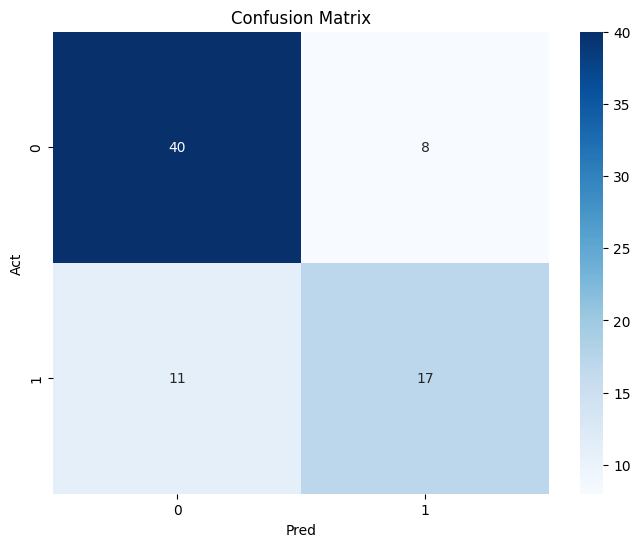

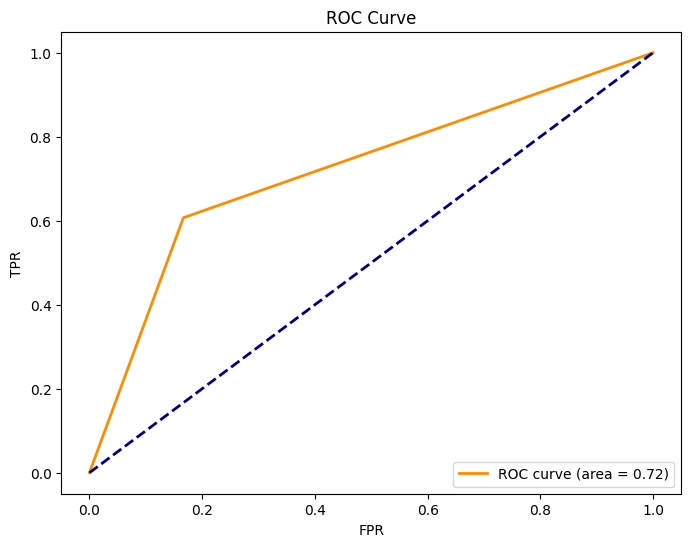

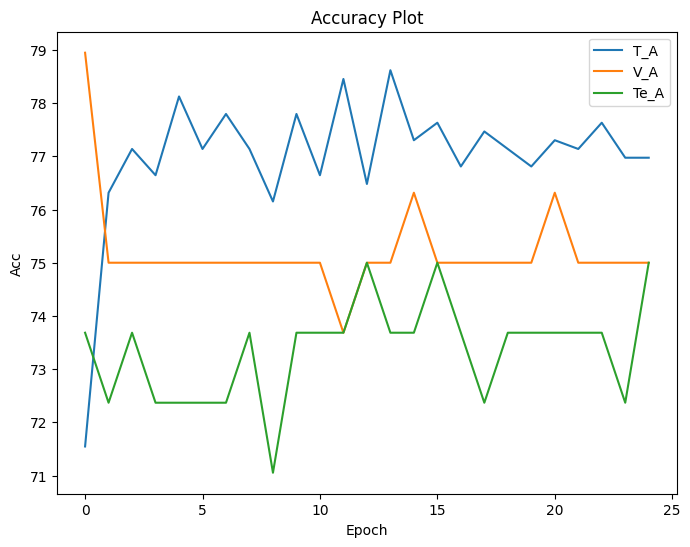

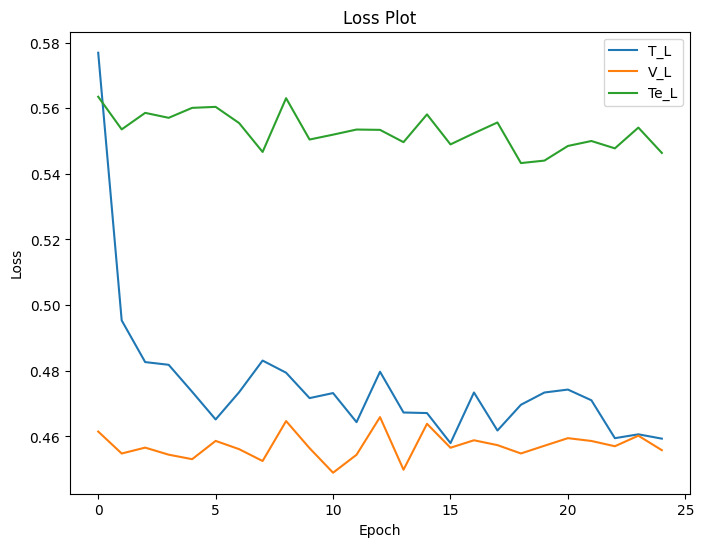

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time


class BC4(nn.Module):
    def __init__(self, dp=0.25, hl_size=64, activation_function=F.relu):
        super(BC4, self).__init__()
        self.l1=nn.Linear(7, hl_size)
        self.l2=nn.Linear(hl_size, 128)
        self.l3=nn.Linear(128, 1)
        self.dp=nn.Dropout(dp)
        self.activation_function=activation_function

    def forward(self, x):
        x=self.activation_function(self.l1(x))
        x=self.dp(x)
        x=self.activation_function(self.l2(x))
        x=self.dp(x)
        x=torch.sigmoid(self.l3(x))
        return x

# Instantiate the model
m4=BC4(dp=0.25, hl_size=64, activation_function=F.elu)
# Get model summary
from torchinfo import summary
ms=summary(m4, input_size=(1, 7))
ms

# Define loss function & optimizer
loss_fn=nn.BCELoss()
opt=Adam(m4.parameters(), lr=0.001)

# Training Loop with Validation and Test Loss
n_e=25
t_l4, v_l4, te_l4, t_a4, v_a4, te_a4 = [], [], [], [], [], []
start_t=time.time()

for e in range(n_e):
    e_start_t=time.time()
    m4.train()
    b_l=[]
    c_t,t_t=0,0

    for i, l in train_dl:
        opt.zero_grad()
        o=m4(i)
        loss=loss_fn(o, l)
        loss.backward()
        opt.step()
        b_l.append(loss.item())

        # Accuracy
        pred=torch.round(o)
        t_t+=l.numel()
        c_t+=int((pred == l).sum())

    t_l4.append(np.mean(b_l))
    t_a4.append(100 * c_t / t_t)

    # Validation
    m4.eval()
    b_v_l=[]
    c_v,t_v=0, 0
    for i, l in val_dl:
        with torch.no_grad():
            o=m4(i)
            v_l_=loss_fn(o, l)
            b_v_l.append(v_l_.item())

            # Accuracy
            pred=torch.round(o)
            t_v+=l.numel()
            c_v+=int((pred==l).sum())

    v_l4.append(np.mean(b_v_l))
    v_a4.append(100 * c_v / t_v)

    # Test
    b_te_l, pred_e, act_e=[], [], []
    for i, l in test_dl:
        with torch.no_grad():
            o=m4(i)
            te_l_=loss_fn(o, l)
            b_te_l.append(te_l_.item())

            pred_val_e=torch.round(o)
            pred_e.extend(pred_val_e.numpy())
            act_e.extend(l.numpy())

    te_l4.append(np.mean(b_te_l))
    te_a_e=accuracy_score(act_e, pred_e)
    te_a4.append(te_a_e * 100)

    e_end_t=time.time()
    e_d=e_end_t-e_start_t
    print(f'Epoch {e+1}/{n_e}, T_L: {t_l4[-1]}, V_L: {v_l4[-1]}, Te_L: {te_l4[-1]}, T_A: {t_a4[-1]}, V_A: {v_a4[-1]}, Te_A: {te_a4[-1]}')

end_t=time.time()
tot_t=end_t - start_t
print(f'Total time: {tot_t:.2f}s ({tot_t/60:.2f}m)')

# Post-training eval
m4.eval()
preds, acts=[], []
with torch.no_grad():
    for i, l in test_dl:
        o=m4(i)
        preds_val=torch.round(o)
        preds.extend(preds_val.numpy())
        acts.extend(l.numpy())

acc=accuracy_score(acts, preds)
pr, re, f1, _=precision_recall_fscore_support(acts, preds, average='binary')
print(f'Acc: {acc}, Pr: {pr}, Re: {re}, F1: {f1}')

# Confusion Matrix
cfm=confusion_matrix(acts, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm,annot=True,fmt="d",cmap="Blues")
plt.ylabel('Act')
plt.xlabel('Pred')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _=roc_curve(acts, preds)
roc_auc=auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr,tpr,color='darkorange',lw=2,label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1],[0, 1],color='navy',lw=2,linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Accuracy plots
e_range=range(n_e)
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_a4,label='T_A')
plt.plot(e_range,v_a4,label='V_A')
plt.plot(e_range,te_a4,label='Te_A')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_l4,label='T_L')
plt.plot(e_range,v_l4,label='V_L')
plt.plot(e_range,te_l4,label='Te_L')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

In [ ]:
# Save model
torch.save(m4.state_dict(),'m4.pth')

Setup - **dp=0.25**, hl_size=64, **activation_function=F.tanh, opt = Adam**

Epoch 1/25, T_L: 0.5580683625058124, V_L: 0.45491841733455657, Te_L: 0.5580450623835388, T_A: 73.1907894736842, V_A: 78.94736842105263, Te_A: 73.68421052631578
Epoch 2/25, T_L: 0.47768851487260117, V_L: 0.44020307064056396, Te_L: 0.5527042027709907, T_A: 77.30263157894737, V_A: 76.3157894736842, Te_A: 72.36842105263158
Epoch 3/25, T_L: 0.46952429296154724, V_L: 0.4459837555885315, Te_L: 0.5528291215580937, T_A: 77.13815789473684, V_A: 76.3157894736842, Te_A: 75.0
Epoch 4/25, T_L: 0.4743876319966818, V_L: 0.4520984649658203, Te_L: 0.5536961632437611, T_A: 77.79605263157895, V_A: 76.3157894736842, Te_A: 73.68421052631578
Epoch 5/25, T_L: 0.47961011764250305, V_L: 0.43979632556438447, Te_L: 0.5412239566396334, T_A: 76.8092105263158, V_A: 75.0, Te_A: 73.68421052631578
Epoch 6/25, T_L: 0.476807643316294, V_L: 0.4523574113845825, Te_L: 0.5458313218857113, T_A: 77.46710526315789, V_A: 75.0, Te_A: 76.31578947368422
Epoch 7/25, T_L: 0.4595923862959209, V_L: 0.4538813352584839, Te_L: 0.552718999

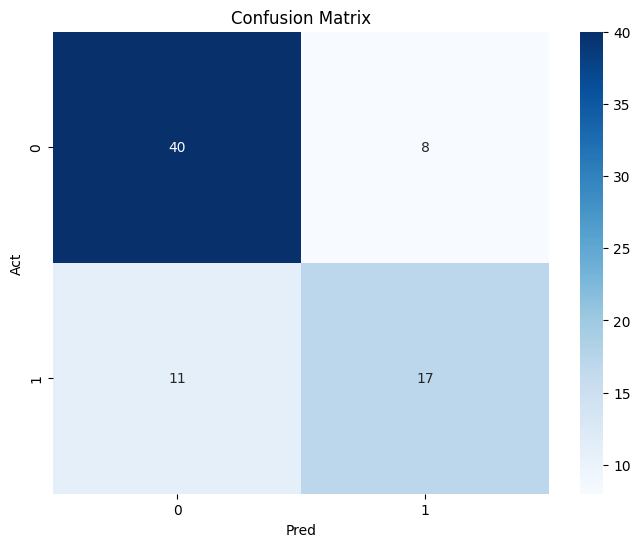

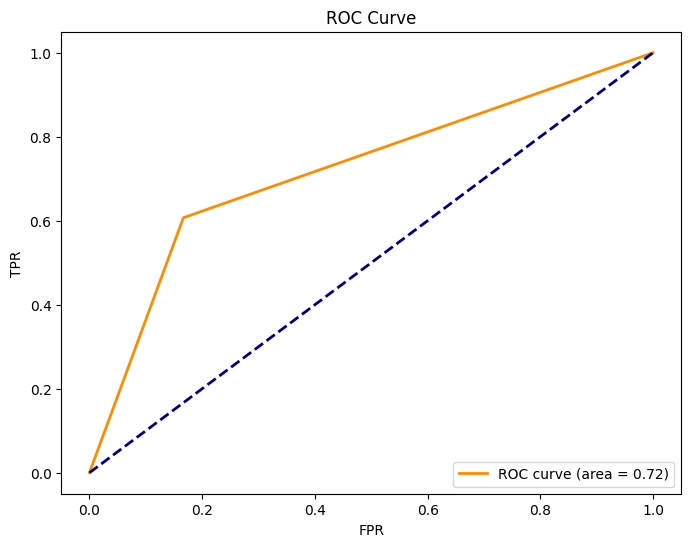

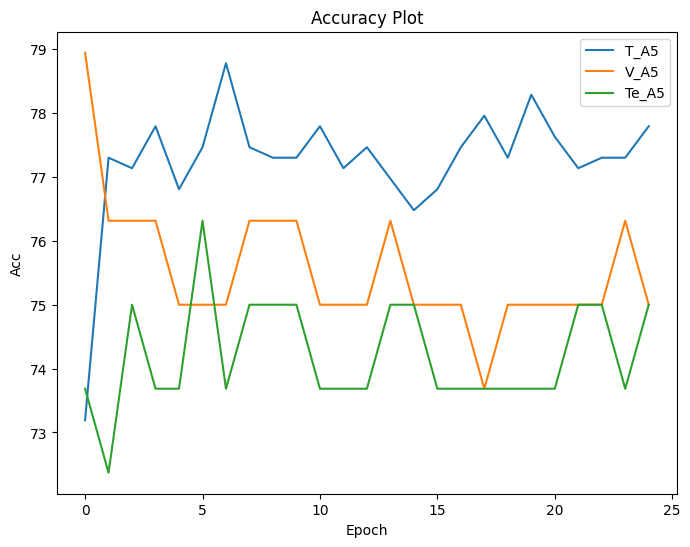

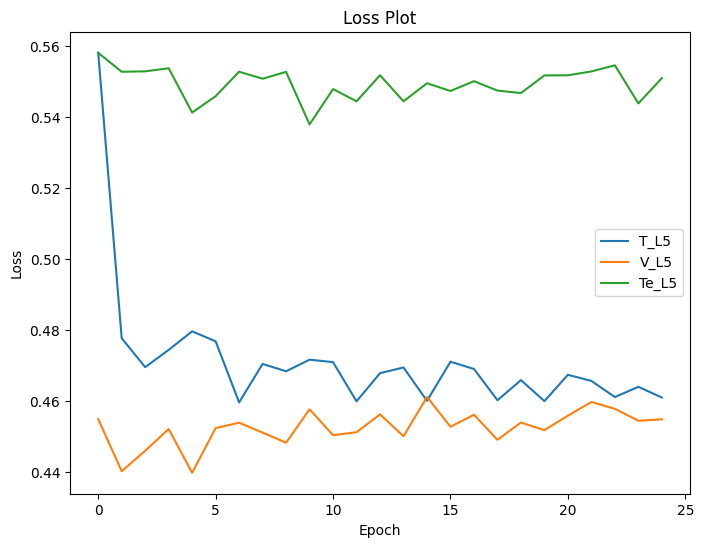

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time


class BC5(nn.Module):
    def __init__(self, dp=0.25, hl_size=64, activation_function=F.relu):
        super(BC5, self).__init__()
        self.l1=nn.Linear(7, hl_size)
        self.l2=nn.Linear(hl_size, 128)
        self.l3=nn.Linear(128, 1)
        self.dp=nn.Dropout(dp)
        self.activation_function = activation_function

    def forward(self, x):
        x=self.activation_function(self.l1(x))
        x=self.dp(x)
        x=self.activation_function(self.l2(x))
        x=self.dp(x)
        x=torch.sigmoid(self.l3(x))
        return x

# Instantiate the model
m5=BC5(dp=0.25, hl_size=64,activation_function=F.tanh)
# Get model summary
from torchinfo import summary
ms=summary(m5, input_size=(1, 7))
ms

# Define loss function & optimizer
loss_fn=nn.BCELoss()
opt=Adam(m5.parameters(), lr=0.001)

# Training Loop with Validation and Test Loss
n_e=25
t_l5, v_l5, te_l5,t_a5,v_a5, te_a5 = [], [], [], [], [], []
start_t=time.time()

for e in range(n_e):
    e_start_t=time.time()
    m5.train()
    b_l=[]
    c_t, t_t=0, 0

    for i, l in train_dl:
        opt.zero_grad()
        o=m5(i)
        loss=loss_fn(o, l)
        loss.backward()
        opt.step()
        b_l.append(loss.item())

        # Accuracy
        pred=torch.round(o)
        t_t+=l.numel()
        c_t+=int((pred == l).sum())

    t_l5.append(np.mean(b_l))
    t_a5.append(100 * c_t / t_t)

    # Validation
    m5.eval()
    b_v_l=[]
    c_v, t_v=0, 0
    for i, l in val_dl:
        with torch.no_grad():
            o=m5(i)
            v_l_=loss_fn(o, l)
            b_v_l.append(v_l_.item())

            # Accuracy
            pred=torch.round(o)
            t_v+=l.numel()
            c_v+=int((pred==l).sum())

    v_l5.append(np.mean(b_v_l))
    v_a5.append(100 * c_v / t_v)

    # Test
    b_te_l, pred_e, act_e=[], [], []
    for i, l in test_dl:
        with torch.no_grad():
            o=m5(i)
            te_l_=loss_fn(o, l)
            b_te_l.append(te_l_.item())

            pred_val_e=torch.round(o)
            pred_e.extend(pred_val_e.numpy())
            act_e.extend(l.numpy())

    te_l5.append(np.mean(b_te_l))
    te_a_e=accuracy_score(act_e, pred_e)
    te_a5.append(te_a_e * 100)

    e_end_t=time.time()
    e_d=e_end_t-e_start_t
    print(f'Epoch {e+1}/{n_e}, T_L: {t_l5[-1]}, V_L: {v_l5[-1]}, Te_L: {te_l5[-1]}, T_A: {t_a5[-1]}, V_A: {v_a5[-1]}, Te_A: {te_a5[-1]}')

end_t=time.time()
tot_t=end_t-start_t
print(f'Total time: {tot_t:.2f}s ({tot_t/60:.2f}m)')

# Post-training eval
m5.eval()
preds, acts=[], []
with torch.no_grad():
    for i, l in test_dl:
        o=m5(i)
        preds_val=torch.round(o)
        preds.extend(preds_val.numpy())
        acts.extend(l.numpy())

acc=accuracy_score(acts, preds)
pr, re, f1, _=precision_recall_fscore_support(acts, preds, average='binary')
print(f'Acc: {acc}, Pr: {pr}, Re: {re}, F1: {f1}')

# Confusion Matrix
cfm=confusion_matrix(acts, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm,annot=True,fmt="d",cmap="Blues")
plt.ylabel('Act')
plt.xlabel('Pred')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _=roc_curve(acts, preds)
roc_auc=auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange',lw=2,label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1],[0, 1],color='navy',lw=2,linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Accuracy plots
e_range=range(n_e)
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_a5,label='T_A5')
plt.plot(e_range,v_a5,label='V_A5')
plt.plot(e_range,te_a5,label='Te_A5')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_l5,label='T_L5')
plt.plot(e_range,v_l5,label='V_L5')
plt.plot(e_range,te_l5,label='Te_L5')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

In [ ]:
# Save model
torch.save(m5.state_dict(),'m5.pth')

Setup 6 - **dp=0.25**, hl_size=64, **activation_function=F.leaky_relu, opt = Adam**

Epoch 1/25, T_L: 0.620794623305923, V_L: 0.519430011510849, Te_L: 0.6102122745819782, T_A: 68.42105263157895, V_A: 77.63157894736842, Te_A: 72.36842105263158
Epoch 2/25, T_L: 0.5299514677179488, V_L: 0.4527881175279617, Te_L: 0.5783736421236474, T_A: 75.32894736842105, V_A: 78.94736842105263, Te_A: 72.36842105263158
Epoch 3/25, T_L: 0.48843516566251455, V_L: 0.4260007679462433, Te_L: 0.5756989068988907, T_A: 77.63157894736842, V_A: 77.63157894736842, Te_A: 72.36842105263158
Epoch 4/25, T_L: 0.4782086336298993, V_L: 0.4275426745414734, Te_L: 0.5656410541912344, T_A: 77.46710526315789, V_A: 77.63157894736842, Te_A: 77.63157894736842
Epoch 5/25, T_L: 0.4840084604526821, V_L: 0.43260487616062165, Te_L: 0.569294209322451, T_A: 77.79605263157895, V_A: 77.63157894736842, Te_A: 75.0
Epoch 6/25, T_L: 0.47435815357848216, V_L: 0.4353259354829788, Te_L: 0.5708464422511353, T_A: 77.96052631578948, V_A: 77.63157894736842, Te_A: 73.68421052631578
Epoch 7/25, T_L: 0.4743928085816534, V_L: 0.446797585

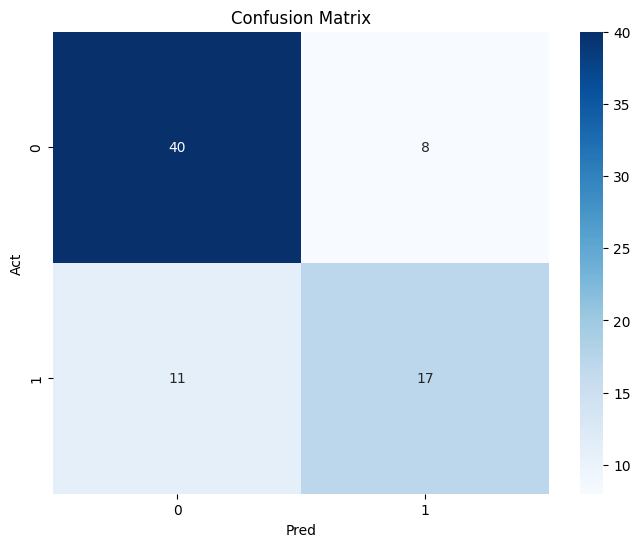

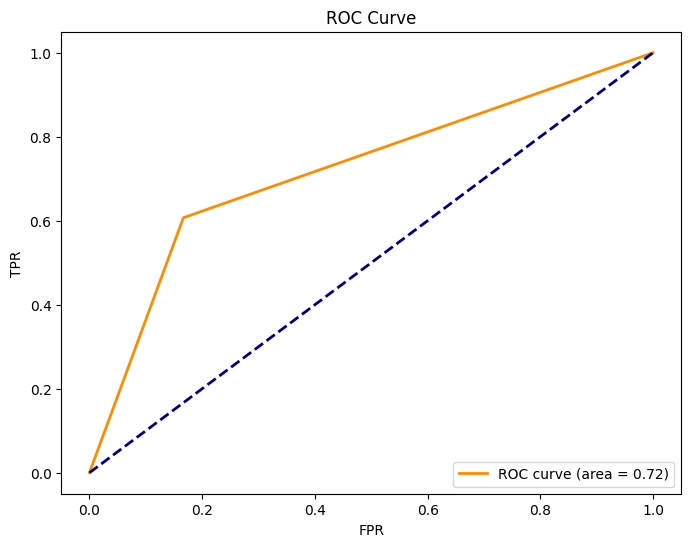

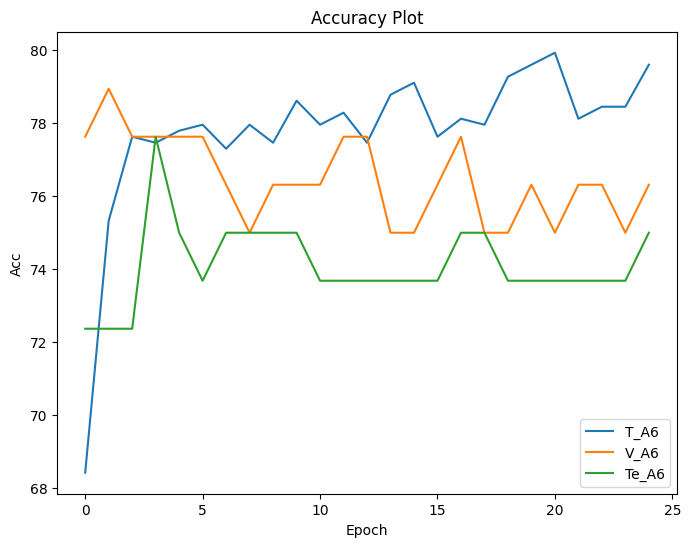

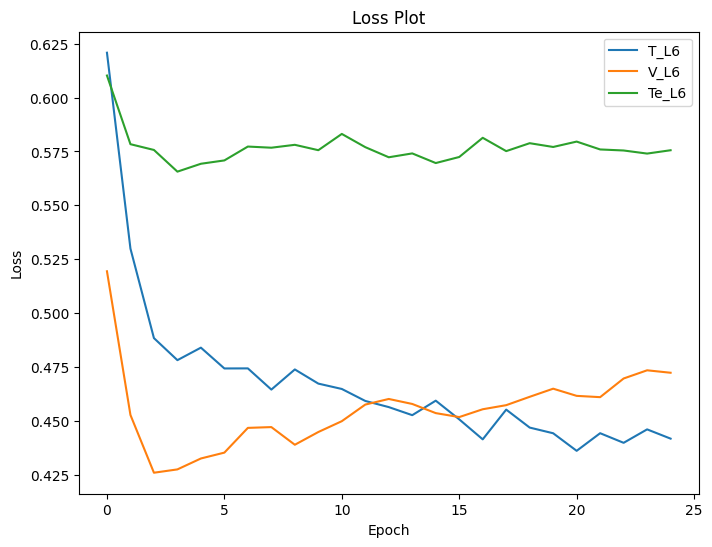

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time


class BC6(nn.Module):
    def __init__(self, dp=0.25, hl_size=64, activation_function=F.relu):
        super(BC6, self).__init__()  # Corrected class name reference
        self.l1=nn.Linear(7, hl_size)
        self.l2=nn.Linear(hl_size, 128)
        self.l3=nn.Linear(128, 1)
        self.dp=nn.Dropout(dp)
        self.activation_function=activation_function

    def forward(self, x):
        x=self.activation_function(self.l1(x))
        x=self.dp(x)
        x=self.activation_function(self.l2(x))
        x=self.dp(x)
        x=torch.sigmoid(self.l3(x))
        return x

# Instantiate the model
m6=BC6(dp=0.25, hl_size=64, activation_function=F.leaky_relu)
# Get model summary
from torchinfo import summary
ms=summary(m6, input_size=(1, 7))
ms

# Define loss function & optimizer
loss_fn=nn.BCELoss()
opt=Adam(m6.parameters(), lr=0.001)

# Training Loop with Validation and Test Loss
n_e=25
t_l6, v_l6, te_l6, t_a6, v_a6, te_a6=[], [], [], [], [], []
start_t=time.time()

for e in range(n_e):
    e_start_t=time.time()
    m6.train()
    b_l=[]
    c_t,t_t=0, 0

    for i, l in train_dl:
        opt.zero_grad()
        o=m6(i)
        loss=loss_fn(o, l)
        loss.backward()
        opt.step()
        b_l.append(loss.item())

        # Accuracy
        pred=torch.round(o)
        t_t+=l.numel()
        c_t+=int((pred == l).sum())

    t_l6.append(np.mean(b_l))
    t_a6.append(100 * c_t / t_t)

    # Validation
    m6.eval()
    b_v_l=[]
    c_v, t_v=0, 0
    for i, l in val_dl:
        with torch.no_grad():
            o=m6(i)
            v_l_=loss_fn(o, l)
            b_v_l.append(v_l_.item())

            # Accuracy
            pred=torch.round(o)
            t_v+=l.numel()
            c_v+=int((pred == l).sum())

    v_l6.append(np.mean(b_v_l))
    v_a6.append(100 * c_v / t_v)

    # Test
    b_te_l, pred_e, act_e=[], [], []
    for i, l in test_dl:
        with torch.no_grad():
            o=m6(i)
            te_l_=loss_fn(o, l)
            b_te_l.append(te_l_.item())

            pred_val_e=torch.round(o)
            pred_e.extend(pred_val_e.numpy())
            act_e.extend(l.numpy())

    te_l6.append(np.mean(b_te_l))
    te_a_e=accuracy_score(act_e, pred_e)
    te_a6.append(te_a_e * 100)

    e_end_t=time.time()
    e_d=e_end_t-e_start_t
    print(f'Epoch {e+1}/{n_e}, T_L: {t_l6[-1]}, V_L: {v_l6[-1]}, Te_L: {te_l6[-1]}, T_A: {t_a6[-1]}, V_A: {v_a6[-1]}, Te_A: {te_a6[-1]}')

end_t=time.time()
tot_t=end_t-start_t
print(f'Total time: {tot_t:.2f}s ({tot_t/60:.2f}m)')

# Post-training eval
m6.eval()
preds, acts=[], []
with torch.no_grad():
    for i, l in test_dl:
        o=m6(i)
        preds_val=torch.round(o)
        preds.extend(preds_val.numpy())
        acts.extend(l.numpy())

acc=accuracy_score(acts, preds)
pr, re, f1, _=precision_recall_fscore_support(acts, preds, average='binary')
print(f'Acc: {acc}, Pr: {pr}, Re: {re}, F1: {f1}')

# Confusion Matrix
cfm=confusion_matrix(acts, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm,annot=True,fmt="d",cmap="Blues")
plt.ylabel('Act')
plt.xlabel('Pred')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _=roc_curve(acts, preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr,color='darkorange',lw=2,label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1],[0, 1],color='navy',lw=2,linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Accuracy plots
e_range=range(n_e)
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_a6,label='T_A6')
plt.plot(e_range,v_a6,label='V_A6')
plt.plot(e_range,te_a6,label='Te_A6')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_l6,label='T_L6')
plt.plot(e_range,v_l6,label='V_L6')
plt.plot(e_range,te_l6,label='Te_L6')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

In [ ]:
# Save model
torch.save(m6.state_dict(),'m6.pth')

Setup 7 - **dp=0.25,** hl_size=64, **activation_function=F.relu, Opt = SGD**

Epoch 1/25, T_L: 0.6904076463297794, V_L: 0.6758373022079468, Te_L: 0.6773841192847804, T_A: 54.76973684210526, V_A: 69.73684210526316, Te_A: 67.10526315789474
Epoch 2/25, T_L: 0.6656734551254072, V_L: 0.649019181728363, Te_L: 0.6636332022516351, T_A: 67.92763157894737, V_A: 68.42105263157895, Te_A: 63.1578947368421
Epoch 3/25, T_L: 0.6500163956692344, V_L: 0.6287687063217163, Te_L: 0.6518533370996776, T_A: 68.09210526315789, V_A: 68.42105263157895, Te_A: 63.1578947368421
Epoch 4/25, T_L: 0.6374282115384152, V_L: 0.611348032951355, Te_L: 0.6418473520561269, T_A: 66.11842105263158, V_A: 68.42105263157895, Te_A: 63.1578947368421
Epoch 5/25, T_L: 0.6163780265732816, V_L: 0.5939440369606018, Te_L: 0.6318300009558075, T_A: 68.09210526315789, V_A: 69.73684210526316, Te_A: 63.1578947368421
Epoch 6/25, T_L: 0.6102667999894995, V_L: 0.5813002467155457, Te_L: 0.6218083179310748, T_A: 68.75, V_A: 68.42105263157895, Te_A: 65.78947368421053
Epoch 7/25, T_L: 0.5992363087440792, V_L: 0.56801253557205

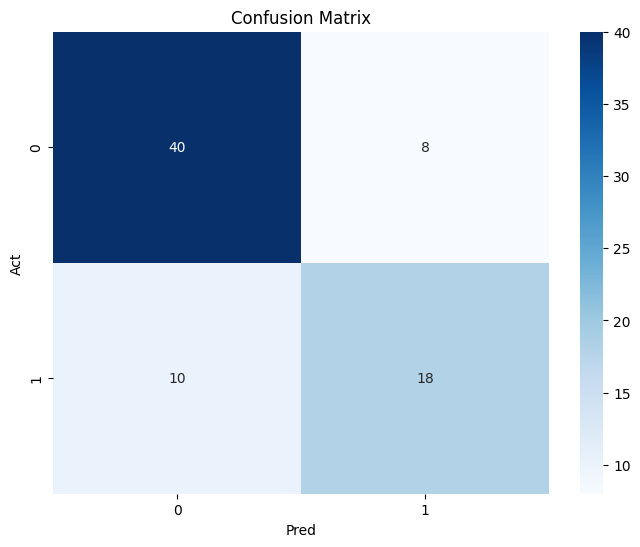

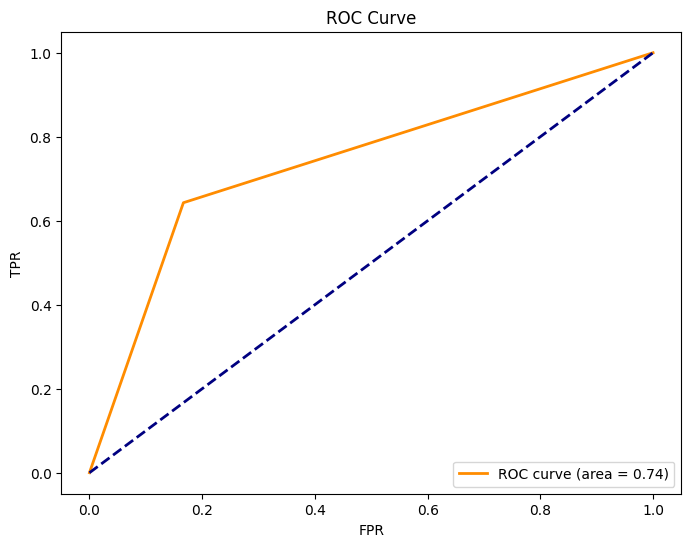

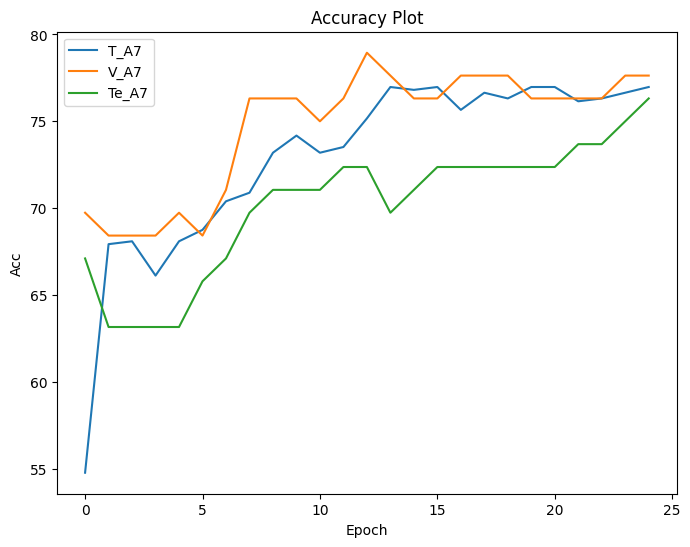

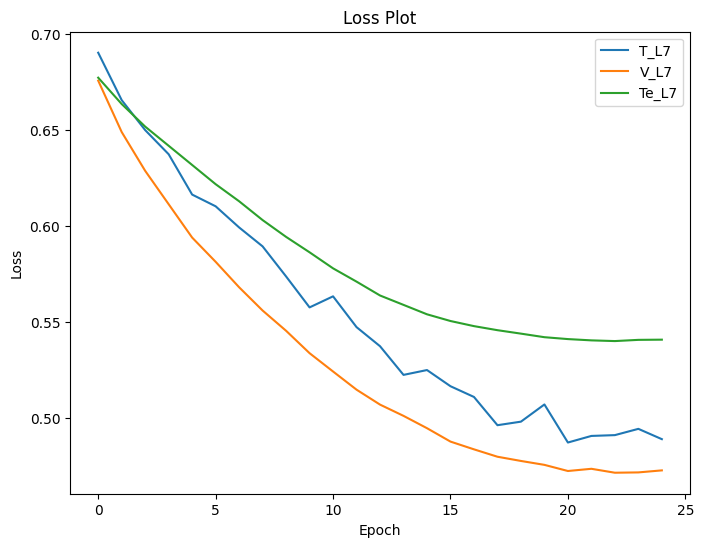

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from torch.optim import SGD


class BC7(nn.Module):
    def __init__(self, dp=0.25, hl_size=64, activation_function=F.relu):
        super(BC7, self).__init__()
        self.l1=nn.Linear(7, hl_size)
        self.l2=nn.Linear(hl_size, 128)
        self.l3=nn.Linear(128, 1)
        self.dp=nn.Dropout(dp)
        self.activation_function = activation_function

    def forward(self, x):
        x=self.activation_function(self.l1(x))
        x=self.dp(x)
        x=self.activation_function(self.l2(x))
        x=self.dp(x)
        x=torch.sigmoid(self.l3(x))
        return x

# Instantiate the model
m7=BC7(dp=0.25, hl_size=64, activation_function=F.relu)
# Get model summary
from torchinfo import summary
ms=summary(m7, input_size=(1, 7))
ms

# Define loss function & optimizer
loss_fn=nn.BCELoss()
opt=SGD(m7.parameters(), lr=0.001, momentum=0.9)

# Training Loop with Validation and Test Loss
n_e=25
t_l7, v_l7, te_l7, t_a7, v_a7, te_a7=[], [], [], [], [], []
start_t=time.time()

for e in range(n_e):
    e_start_t=time.time()
    m7.train()
    b_l=[]
    c_t, t_t=0, 0

    for i, l in train_dl:
        opt.zero_grad()
        o=m7(i)
        loss=loss_fn(o, l)
        loss.backward()
        opt.step()
        b_l.append(loss.item())

        # Accuracy
        pred=torch.round(o)
        t_t+=l.numel()
        c_t+=int((pred==l).sum())

    t_l7.append(np.mean(b_l))
    t_a7.append(100 * c_t / t_t)

    # Validation
    m7.eval()
    b_v_l=[]
    c_v, t_v=0, 0
    for i, l in val_dl:
        with torch.no_grad():
            o=m7(i)
            v_l_=loss_fn(o, l)
            b_v_l.append(v_l_.item())

            # Accuracy
            pred=torch.round(o)
            t_v+=l.numel()
            c_v+=int((pred==l).sum())

    v_l7.append(np.mean(b_v_l))
    v_a7.append(100 * c_v / t_v)

    # Test
    b_te_l, pred_e, act_e=[], [], []
    for i, l in test_dl:
        with torch.no_grad():
            o=m7(i)
            te_l_=loss_fn(o, l)
            b_te_l.append(te_l_.item())

            pred_val_e=torch.round(o)
            pred_e.extend(pred_val_e.numpy())
            act_e.extend(l.numpy())

    te_l7.append(np.mean(b_te_l))
    te_a_e = accuracy_score(act_e, pred_e)
    te_a7.append(te_a_e * 100)

    e_end_t=time.time()
    e_d=e_end_t-e_start_t
    print(f'Epoch {e+1}/{n_e}, T_L: {t_l7[-1]}, V_L: {v_l7[-1]}, Te_L: {te_l7[-1]}, T_A: {t_a7[-1]}, V_A: {v_a7[-1]}, Te_A: {te_a7[-1]}')

end_t=time.time()
tot_t=end_t-start_t
print(f'Total time: {tot_t:.2f}s ({tot_t/60:.2f}m)')

# Post-training eval
m7.eval()
preds, acts=[], []
with torch.no_grad():
    for i, l in test_dl:
        o=m7(i)
        preds_val=torch.round(o)
        preds.extend(preds_val.numpy())
        acts.extend(l.numpy())

acc=accuracy_score(acts, preds)
pr, re, f1, _=precision_recall_fscore_support(acts, preds, average='binary')
print(f'Acc: {acc}, Pr: {pr}, Re: {re}, F1: {f1}')

# Confusion Matrix
cfm=confusion_matrix(acts, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm,annot=True,fmt="d",cmap="Blues")
plt.ylabel('Act')
plt.xlabel('Pred')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _=roc_curve(acts, preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr,tpr,color='darkorange',lw=2,label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1],color='navy',lw=2,linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Accuracy plots
e_range=range(n_e)
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_a7,label='T_A7')
plt.plot(e_range,v_a7,label='V_A7')
plt.plot(e_range,te_a7,label='Te_A7')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_l7,label='T_L7')
plt.plot(e_range,v_l7,label='V_L7')
plt.plot(e_range,te_l7,label='Te_L7')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

In [ ]:
# Save model
torch.save(m7.state_dict(),'m7.pth')

Setup 8 - **dp=0.25,** hl_size=64, **activation_function=F.relu, opt = SparseAdam**

Epoch 1/25, T_L: 0.5378530668584924, V_L: 0.4212828516960144, Te_L: 0.5931078697766153, T_A: 73.84868421052632, V_A: 76.3157894736842, Te_A: 73.68421052631578
Epoch 2/25, T_L: 0.4828132673313743, V_L: 0.4495737135410309, Te_L: 0.5785338707378527, T_A: 77.63157894736842, V_A: 73.6842105263158, Te_A: 75.0
Epoch 3/25, T_L: 0.4805394066007514, V_L: 0.4258326679468155, Te_L: 0.5900163118418086, T_A: 77.46710526315789, V_A: 77.63157894736842, Te_A: 73.68421052631578
Epoch 4/25, T_L: 0.47523320466279984, V_L: 0.43288929760456085, Te_L: 0.5914406866642438, T_A: 77.46710526315789, V_A: 75.0, Te_A: 73.68421052631578
Epoch 5/25, T_L: 0.4734104365894669, V_L: 0.4462206333875656, Te_L: 0.588619803599278, T_A: 77.79605263157895, V_A: 75.0, Te_A: 75.0
Epoch 6/25, T_L: 0.4782994083668056, V_L: 0.45313291549682616, Te_L: 0.5713174096032928, T_A: 77.79605263157895, V_A: 73.6842105263158, Te_A: 75.0
Epoch 7/25, T_L: 0.45933246887043905, V_L: 0.4666211009025574, Te_L: 0.5723152321588714, T_A: 78.947368421

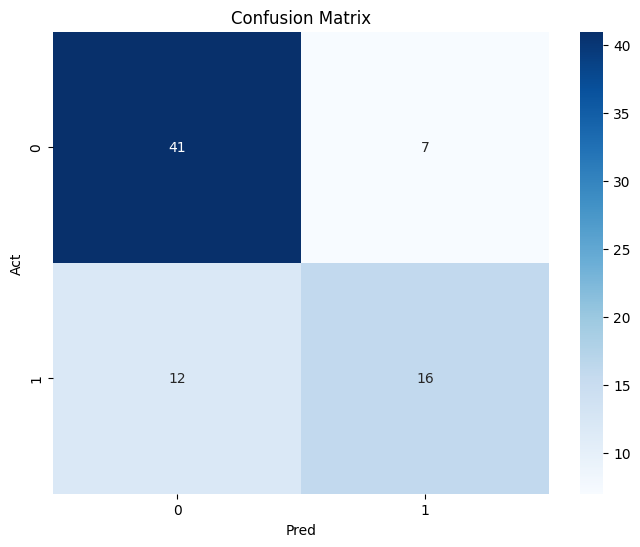

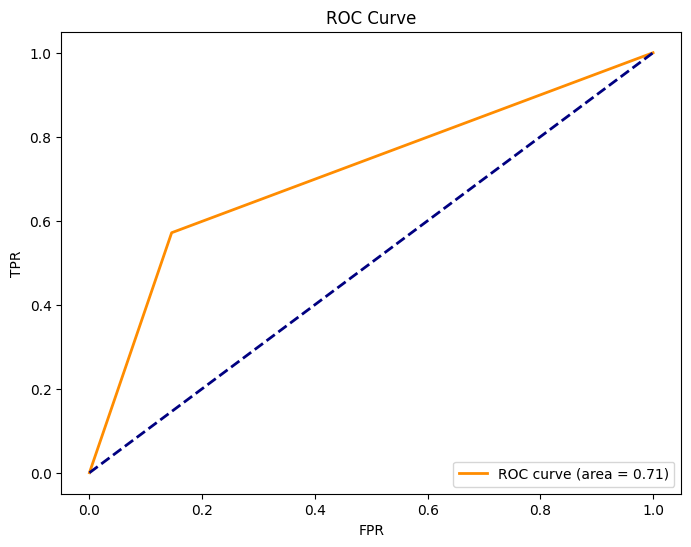

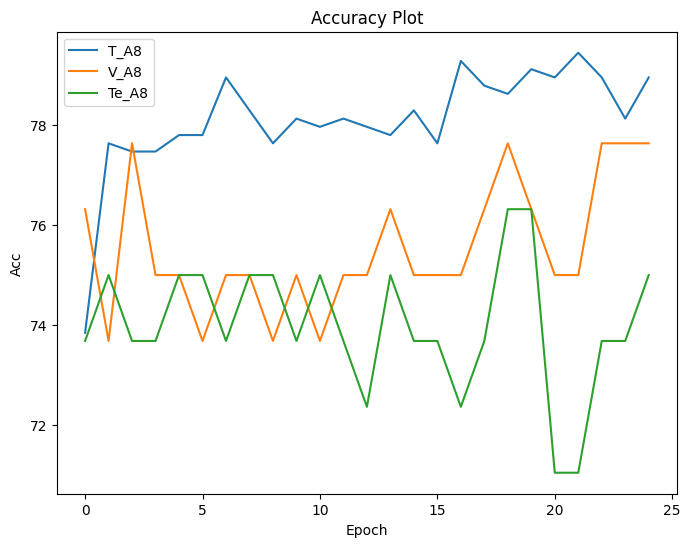

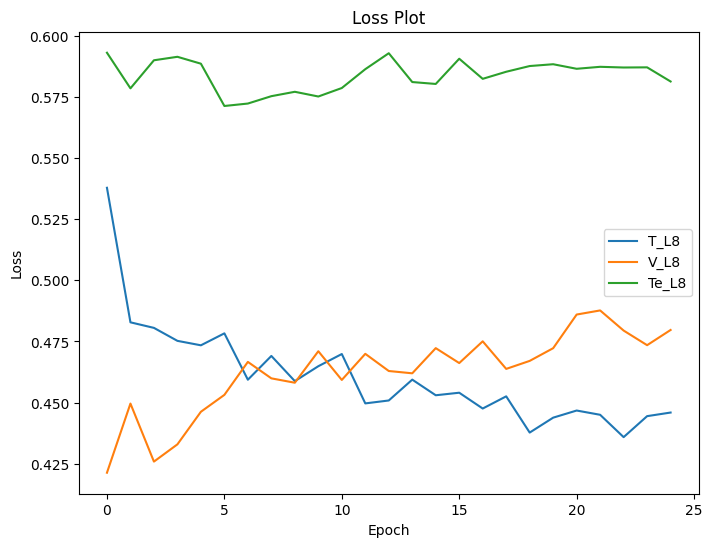

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.optim import RMSprop


class BC8(nn.Module):
    def __init__(self, dp=0.25, hl_size=64, activation_function=F.relu):
        super(BC8, self).__init__()
        self.l1=nn.Linear(7, hl_size)
        self.l2=nn.Linear(hl_size, 128)
        self.l3=nn.Linear(128, 1)
        self.dp=nn.Dropout(dp)
        self.activation_function = activation_function

    def forward(self, x):
        x=self.activation_function(self.l1(x))
        x=self.dp(x)
        x=self.activation_function(self.l2(x))
        x=self.dp(x)
        x=torch.sigmoid(self.l3(x))
        return x

# Instantiate the model
m8=BC8(dp=0.25, hl_size=64, activation_function=F.relu)
# Get model summary
from torchinfo import summary
ms=summary(m8, input_size=(1, 7))
ms

# Define loss function & optimizer
loss_fn=nn.BCELoss()
opt=RMSprop(m8.parameters(), lr=0.001, alpha=0.99)

# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import seaborn as sns
import time

# Training Loop with Validation and Test Loss
n_e=25
t_l8, v_l8, te_l8, t_a8, v_a8, te_a8=[], [], [], [], [], []
start_t = time.time()

for e in range(n_e):
    e_start_t=time.time()
    m8.train()
    b_l=[]
    c_t, t_t=0, 0

    for i, l in train_dl:
        opt.zero_grad()
        o=m8(i)
        loss=loss_fn(o, l)
        loss.backward()
        opt.step()
        b_l.append(loss.item())

        # Accuracy
        pred=torch.round(o)
        t_t+=l.numel()
        c_t+=int((pred == l).sum())

    t_l8.append(np.mean(b_l))
    t_a8.append(100 * c_t / t_t)

    # Validation
    m8.eval()
    b_v_l=[]
    c_v, t_v=0, 0
    for i, l in val_dl:
        with torch.no_grad():
            o=m8(i)
            v_l_=loss_fn(o, l)
            b_v_l.append(v_l_.item())

            # Accuracy
            pred=torch.round(o)
            t_v+=l.numel()
            c_v+=int((pred == l).sum())

    v_l8.append(np.mean(b_v_l))
    v_a8.append(100 * c_v / t_v)

    # Test
    b_te_l, pred_e, act_e=[], [], []
    for i, l in test_dl:
        with torch.no_grad():
            o=m8(i)
            te_l_=loss_fn(o, l)
            b_te_l.append(te_l_.item())

            pred_val_e=torch.round(o)
            pred_e.extend(pred_val_e.numpy())
            act_e.extend(l.numpy())

    te_l8.append(np.mean(b_te_l))
    te_a_e=accuracy_score(act_e, pred_e)
    te_a8.append(te_a_e * 100)

    e_end_t=time.time()
    e_d=e_end_t-e_start_t
    print(f'Epoch {e+1}/{n_e}, T_L: {t_l8[-1]}, V_L: {v_l8[-1]}, Te_L: {te_l8[-1]}, T_A: {t_a8[-1]}, V_A: {v_a8[-1]}, Te_A: {te_a8[-1]}')

end_t=time.time()
tot_t=end_t-start_t
print(f'Total time: {tot_t:.2f}s ({tot_t/60:.2f}m)')

# Post-training eval
m8.eval()
preds, acts=[], []
with torch.no_grad():
    for i, l in test_dl:
        o=m8(i)
        preds_val=torch.round(o)
        preds.extend(preds_val.numpy())
        acts.extend(l.numpy())

acc=accuracy_score(acts, preds)
pr, re, f1, _=precision_recall_fscore_support(acts, preds, average='binary')
print(f'Acc: {acc}, Pr: {pr}, Re: {re}, F1: {f1}')

# Confusion Matrix
cfm=confusion_matrix(acts, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Act')
plt.xlabel('Pred')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _=roc_curve(acts, preds)
roc_auc=auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr,color='darkorange',lw=2,label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1],[0, 1],color='navy',lw=2,linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Accuracy plots
e_range=range(n_e)
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_a8,label='T_A8')
plt.plot(e_range,v_a8,label='V_A8')
plt.plot(e_range,te_a8,label='Te_A8')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_l8,label='T_L8')
plt.plot(e_range,v_l8,label='V_L8')
plt.plot(e_range,te_l8,label='Te_L8')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

In [ ]:
# Save model
torch.save(m8.state_dict(),'m8.pth')

Setup 9 - **dp=0.25,** hl_size=64, **activation_function=F.relu, opt = AdamW**

Epoch 1/25, T_L: 0.6378518437084398, V_L: 0.5393273890018463, Te_L: 0.6260803873209577, T_A: 65.78947368421052, V_A: 68.42105263157895, Te_A: 69.73684210526315
Epoch 2/25, T_L: 0.5493036194851524, V_L: 0.4557252287864685, Te_L: 0.5983897621841415, T_A: 73.51973684210526, V_A: 77.63157894736842, Te_A: 73.68421052631578
Epoch 3/25, T_L: 0.5037831256264135, V_L: 0.4533521682024002, Te_L: 0.5840815751335436, T_A: 75.16447368421052, V_A: 77.63157894736842, Te_A: 73.68421052631578
Epoch 4/25, T_L: 0.4785379038045281, V_L: 0.44862706363201144, Te_L: 0.5736980643552286, T_A: 77.79605263157895, V_A: 77.63157894736842, Te_A: 71.05263157894737
Epoch 5/25, T_L: 0.4751570138492082, V_L: 0.4508309602737427, Te_L: 0.5744855741565851, T_A: 78.28947368421052, V_A: 76.3157894736842, Te_A: 69.73684210526315
Epoch 6/25, T_L: 0.4778538695291469, V_L: 0.47154332101345064, Te_L: 0.5675794473959526, T_A: 76.64473684210526, V_A: 75.0, Te_A: 72.36842105263158
Epoch 7/25, T_L: 0.4633415976637288, V_L: 0.46245541

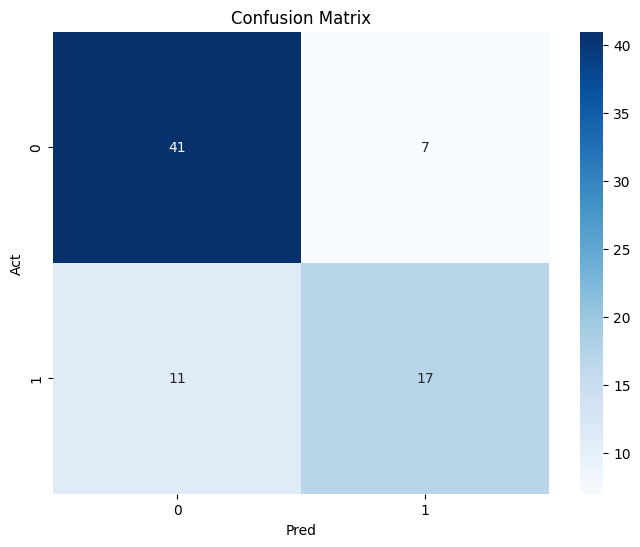

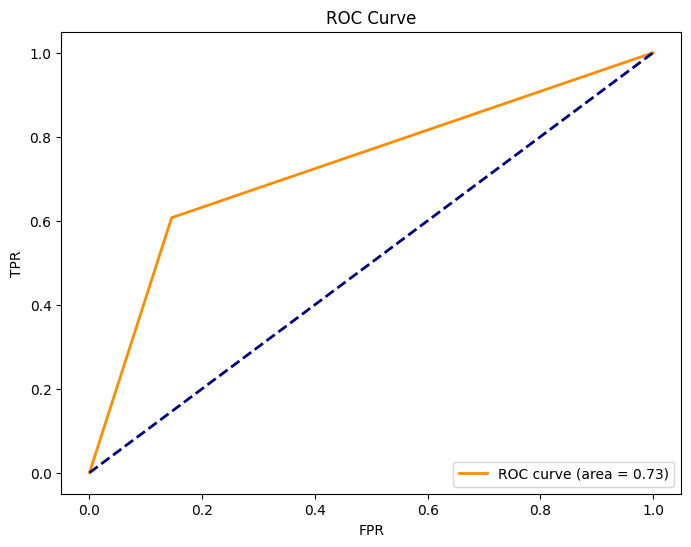

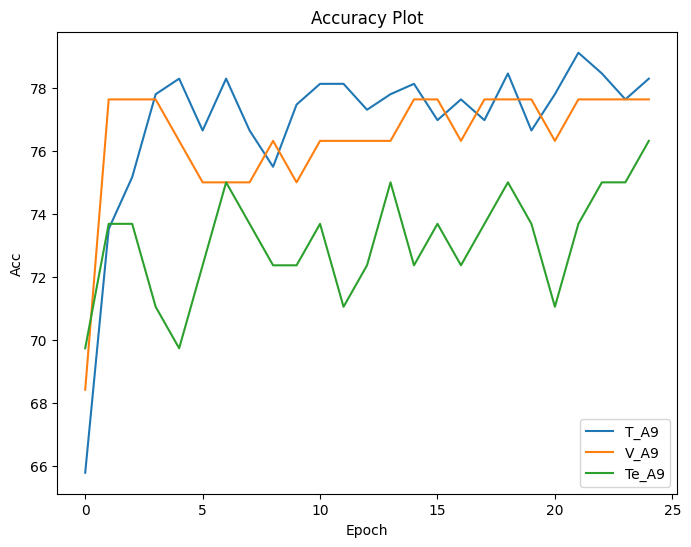

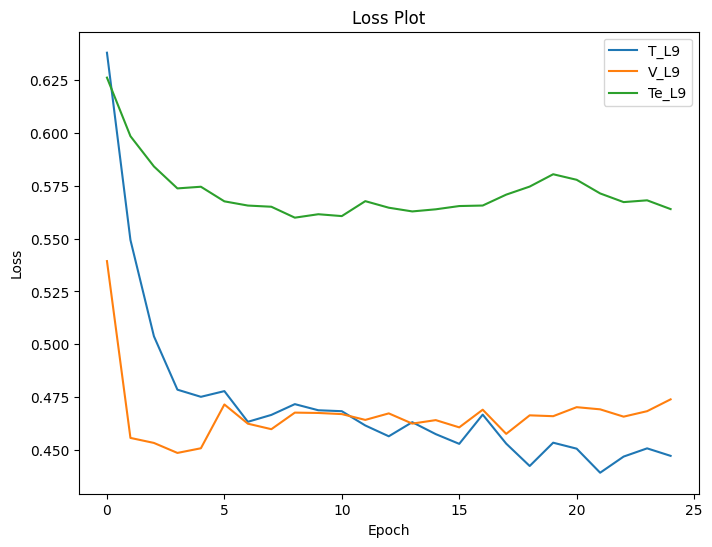

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from torch.optim import AdamW


class BC9(nn.Module):
    def __init__(self, dp=0.25, hl_size=64, activation_function=F.relu):
        super(BC9, self).__init__()  # Adjusted the superclass call to BC1
        self.l1=nn.Linear(7, hl_size)
        self.l2=nn.Linear(hl_size, 128)
        self.l3=nn.Linear(128, 1)
        self.dp=nn.Dropout(dp)
        self.activation_function = activation_function

    def forward(self, x):
        x=self.activation_function(self.l1(x))
        x=self.dp(x)
        x=self.activation_function(self.l2(x))
        x=self.dp(x)
        x=torch.sigmoid(self.l3(x))
        return x

# Instantiate the model
m9=BC9()
# Get model summary
from torchinfo import summary
ms=summary(m9, input_size=(1, 7))
ms

# Define loss function & optimizer
loss_fn=nn.BCELoss()
opt=AdamW(m9.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)

# Training Loop with Validation and Test Loss
n_e=25
t_l9, v_l9, te_l9, t_a9, v_a9, te_a9 = [], [], [], [], [], []
start_t=time.time()

for e in range(n_e):
    e_start_t=time.time()
    m9.train()
    b_l=[]
    c_t, t_t=0, 0

    for i, l in train_dl:
        opt.zero_grad()
        o=m9(i)
        loss=loss_fn(o, l)
        loss.backward()
        opt.step()
        b_l.append(loss.item())

        # Accuracy
        pred=torch.round(o)
        t_t+=l.numel()
        c_t+=int((pred==l).sum())

    t_l9.append(np.mean(b_l))
    t_a9.append(100 * c_t / t_t)

    # Validation
    m9.eval()
    b_v_l = []
    c_v, t_v=0, 0
    for i, l in val_dl:
        with torch.no_grad():
            o=m9(i)
            v_l_=loss_fn(o, l)
            b_v_l.append(v_l_.item())

            # Accuracy
            pred=torch.round(o)
            t_v+=l.numel()
            c_v+=int((pred == l).sum())

    v_l9.append(np.mean(b_v_l))
    v_a9.append(100 * c_v / t_v)

    # Test
    b_te_l, pred_e, act_e=[], [], []
    for i, l in test_dl:
        with torch.no_grad():
            o=m9(i)
            te_l_=loss_fn(o, l)
            b_te_l.append(te_l_.item())

            pred_val_e=torch.round(o)
            pred_e.extend(pred_val_e.numpy())
            act_e.extend(l.numpy())

    te_l9.append(np.mean(b_te_l))
    te_a_e=accuracy_score(act_e, pred_e)
    te_a9.append(te_a_e * 100)

    e_end_t=time.time()
    e_d=e_end_t-e_start_t
    print(f'Epoch {e+1}/{n_e}, T_L: {t_l9[-1]}, V_L: {v_l9[-1]}, Te_L: {te_l9[-1]}, T_A: {t_a9[-1]}, V_A: {v_a9[-1]}, Te_A: {te_a9[-1]}')

end_t=time.time()
tot_t=end_t-start_t
print(f'Total time: {tot_t:.2f}s ({tot_t/60:.2f}m)')

# Post-training eval
m9.eval()
preds, acts=[], []
with torch.no_grad():
    for i, l in test_dl:
        o=m9(i)
        preds_val=torch.round(o)
        preds.extend(preds_val.numpy())
        acts.extend(l.numpy())

acc=accuracy_score(acts, preds)
pr, re, f1, _=precision_recall_fscore_support(acts, preds, average='binary')
print(f'Acc: {acc}, Pr: {pr}, Re: {re}, F1: {f1}')

# Confusion Matrix
cfm=confusion_matrix(acts, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Act')
plt.xlabel('Pred')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _=roc_curve(acts, preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr,color='darkorange',lw=2,label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1],[0, 1],color='navy',lw=2,linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Accuracy plots
e_range=range(n_e)
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_a9,label='T_A9')
plt.plot(e_range,v_a9,label='V_A9')
plt.plot(e_range,te_a9,label='Te_A9')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_l9,label='T_L9')
plt.plot(e_range,v_l9,label='V_L9')
plt.plot(e_range,te_l9,label='Te_L9')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

In [ ]:
# Save model
torch.save(m9.state_dict(), 'm9.pth')

Optimization - Early Stopping

Epoch 1/25, T_L: 0.6871428348516163, V_L: 0.6635340571403503, Te_L: 0.6754413239265743, T_A: 55.26315789473684, V_A: 71.05263157894737, Te_A: 63.1578947368421
Epoch 2/25, T_L: 0.6626314034587458, V_L: 0.6350760340690613, Te_L: 0.6617964451250277, T_A: 68.25657894736842, V_A: 69.73684210526316, Te_A: 60.526315789473685
Epoch 3/25, T_L: 0.6457880217778055, V_L: 0.6123914361000061, Te_L: 0.6509449646661156, T_A: 65.95394736842105, V_A: 69.73684210526316, Te_A: 63.1578947368421
Epoch 4/25, T_L: 0.6283985439099764, V_L: 0.5941515922546386, Te_L: 0.6405974963777944, T_A: 68.25657894736842, V_A: 69.73684210526316, Te_A: 60.526315789473685
Epoch 5/25, T_L: 0.6172038606907192, V_L: 0.5786294102668762, Te_L: 0.6308397466414853, T_A: 67.92763157894737, V_A: 72.36842105263158, Te_A: 65.78947368421053
Epoch 6/25, T_L: 0.6037394671063674, V_L: 0.5634032547473907, Te_L: 0.6225075629588804, T_A: 69.24342105263158, V_A: 71.05263157894737, Te_A: 65.78947368421053
Epoch 7/25, T_L: 0.584905375775538, V_L:

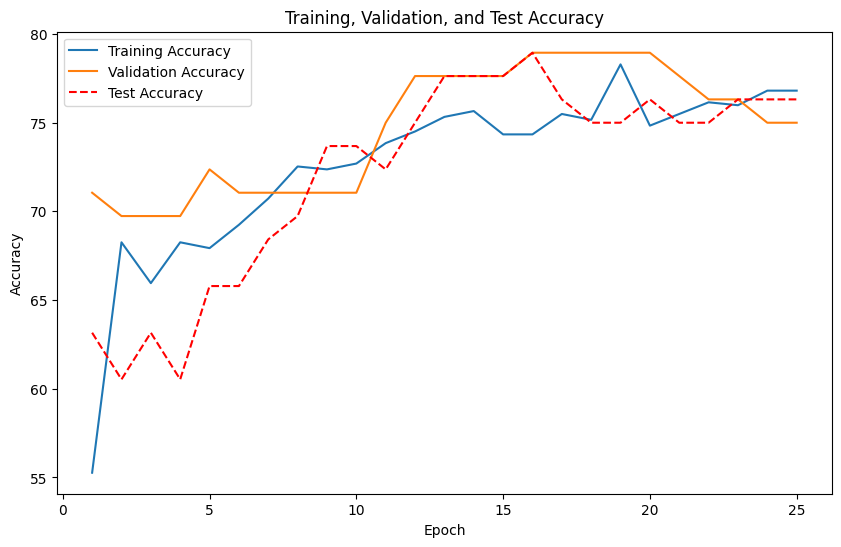

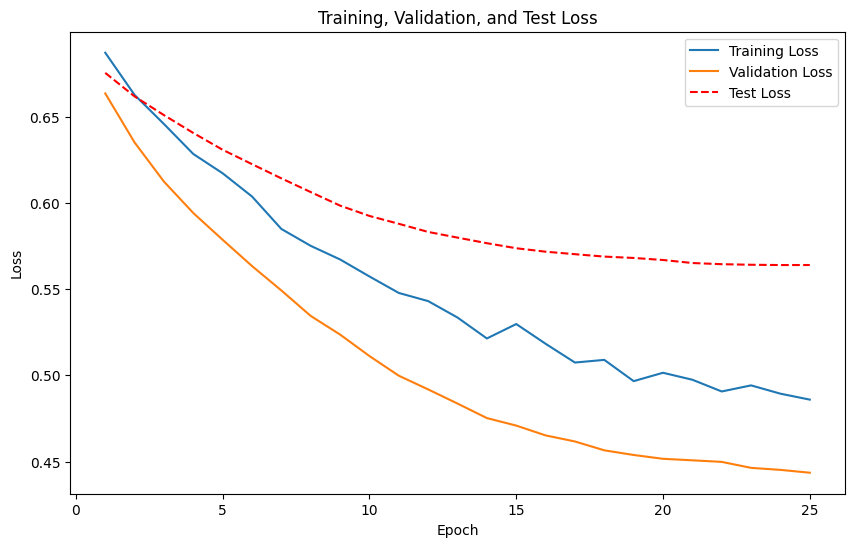

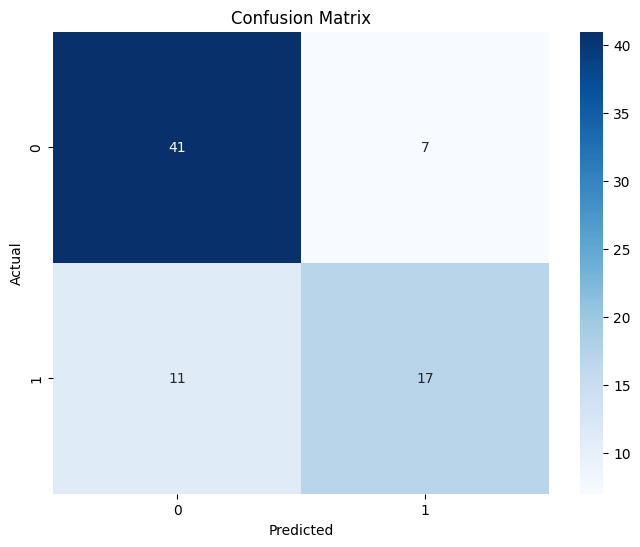

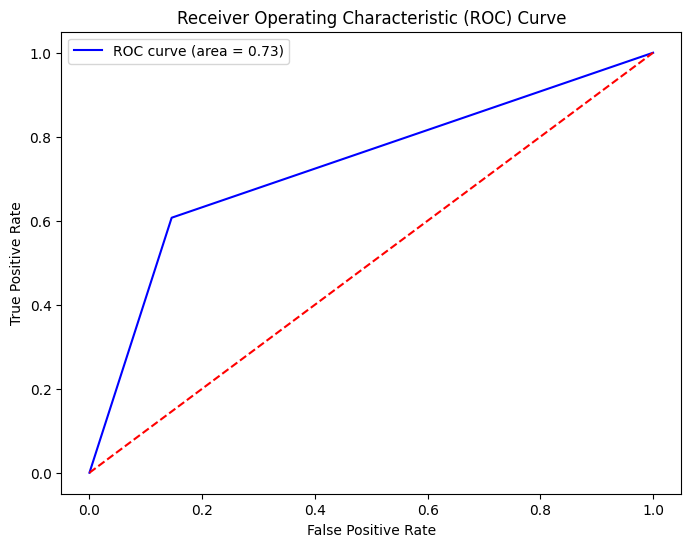

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time




# Instantiate the model
mES=BC7(dp=0.25, hl_size=64, activation_function=F.relu)

# Define loss function & optimizer
loss_fn=nn.BCELoss()
opt=SGD(mES.parameters(), lr=0.001, momentum=0.9)

# Initialize early stopping variables
best_val_loss=float("inf")
patience=10
wait=0

# Training Loop with Validation and Test Loss
n_e=25
t_l_ES, v_l_ES, te_l_ES, t_a_ES, v_a_ES, te_a_ES=[], [], [], [], [], []
start_t=time.time()

for e in range(n_e):
    e_start_t=time.time()
    mES.train()
    b_l=[]
    c_t, t_t=0, 0

    for i, l in train_dl:
        opt.zero_grad()
        o=mES(i)
        loss=loss_fn(o, l)
        loss.backward()
        opt.step()
        b_l.append(loss.item())

        # Accuracy
        pred=torch.round(o)
        t_t+=l.numel()
        c_t+=int((pred == l).sum())

    t_l_ES.append(np.mean(b_l))
    t_a_ES.append(100 * c_t / t_t)

    # Validation
    mES.eval()
    b_v_l=[]
    c_v, t_v=0, 0
    for i, l in val_dl:
        with torch.no_grad():
            o=mES(i)
            v_l_=loss_fn(o, l)
            b_v_l.append(v_l_.item())

            # Accuracy
            pred=torch.round(o)
            t_v+=l.numel()
            c_v+=int((pred == l).sum())

    v_l_ES.append(np.mean(b_v_l))
    v_a_ES.append(100 * c_v / t_v)

    # Test
    b_te_l, pred_e, act_e=[], [], []
    for i, l in test_dl:
        with torch.no_grad():
            o=mES(i)
            te_l_=loss_fn(o, l)
            b_te_l.append(te_l_.item())

            pred_val_e=torch.round(o)
            pred_e.extend(pred_val_e.numpy())
            act_e.extend(l.numpy())

    te_l_ES.append(np.mean(b_te_l))
    te_a_e=accuracy_score(act_e, pred_e)
    te_a_ES.append(te_a_e * 100)

    e_end_t=time.time()
    e_d=e_end_t-e_start_t
    print(f'Epoch {e+1}/{n_e}, T_L: {t_l_ES[-1]}, V_L: {v_l_ES[-1]}, Te_L: {te_l_ES[-1]}, T_A: {t_a_ES[-1]}, V_A: {v_a_ES[-1]}, Te_A: {te_a_ES[-1]}')

    # Check early stopping condition
    if v_l_ES[-1]<best_val_loss:
        best_val_loss=v_l_ES[-1]
        wait=0  # reset the wait time
        # Save the best model
        torch.save(mES.state_dict(), 'best_model.pth')
    else:
        wait+=1
        if wait>=patience:
            print("Early stopping")
            break

end_t=time.time()
tot_t=end_t-start_t
print(f'Total time: {tot_t:.2f}s ({tot_t/60:.2f}m)')

# Load the best model
mES.load_state_dict(torch.load('best_model.pth'))

# Post-training eval
mES.eval()
preds, acts=[], []
with torch.no_grad():
    for i, l in test_dl:
        o = mES(i)
        preds_val = torch.round(o)
        preds.extend(preds_val.numpy())
        acts.extend(l.numpy())

acc=accuracy_score(acts, preds)
pr, re, f1, _=precision_recall_fscore_support(acts, preds, average='binary')
print(f'Acc: {acc}, Pr: {pr}, Re: {re}, F1: {f1}')

# Plotting

e_range=range(1, len(t_l_ES) + 1)

# Accuracy plots
plt.figure(figsize=(10, 6))
plt.plot(e_range,t_a_ES,label='Training Accuracy')
plt.plot(e_range,v_a_ES,label='Validation Accuracy')
plt.plot(e_range,te_a_ES, 'r--',label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(10, 6))
plt.plot(e_range,t_l_ES,label='Training Loss')
plt.plot(e_range,v_l_ES,label='Validation Loss')
plt.plot(e_range,te_l_ES,'r--',label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.show()

# Confusion Matrix
cfm=confusion_matrix(acts, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm,annot=True,fmt="d",cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
fpr, tpr, _=roc_curve(acts,preds)
roc_auc=auc(fpr,tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr,tpr,color='blue',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1],[0, 1],color='red',linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Epochs range: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


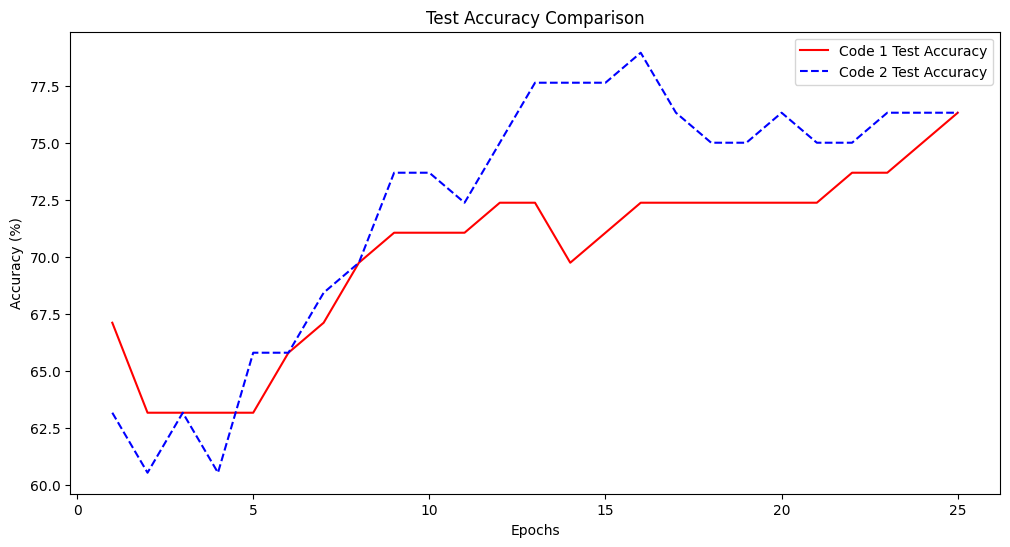

In [ ]:
min_epochs=min(len(te_a7), len(te_a_ES))
epochs=range(1, min_epochs + 1)
print("Epochs range:", list(epochs))
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
base_model_acc=te_a7[:min_epochs]
early_stopping_acc=te_a_ES[:min_epochs]
plt.plot(epochs, base_model_acc, 'r', label='Code 1 Test Accuracy')
plt.plot(epochs, early_stopping_acc, 'b--', label='Code 2 Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

Optimization - Kfold

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Preparing the full dataset by combining training, validation, and test sets
Xf=torch.Tensor(Xc.to_numpy())  # Convert to a tensor
yf=torch.Tensor(yc.values).unsqueeze(1)  # Convert labels to tensor

nf=5  # Number of folds
kf=KFold(n_splits=nf, shuffle=True)

fold_accs=[]  # Store each fold's accuracies here (each as a list)
num_epochs=25
# K-Fold Cross-Validation - Model Evaluation
for fi, (tr_i, te_i) in enumerate(kf.split(Xf)):
    Xt_tr, Xt_te=Xf[tr_i], Xf[te_i]
    yt_tr, yt_te=yf[tr_i], yf[te_i]

    ds_tr=TensorDataset(Xt_tr, yt_tr)
    dl_tr=DataLoader(ds_tr, batch_size=16, shuffle=True)

    ds_te=TensorDataset(Xt_te, yt_te)
    dl_te=DataLoader(ds_te, batch_size=1, shuffle=False)

    model=BC7()
    crit=nn.BCELoss()
    opt=SGD(model.parameters(), lr=0.001, momentum=0.9)

    e_accs=[]  # Accuracies for each epoch within a fold

    for e in range(num_epochs):
        model.train()

        for Xb, yb in dl_tr:
            opt.zero_grad()
            out=model(Xb)
            loss=crit(out, yb)
            loss.backward()
            opt.step()

        c_te, t_te=0, 0
        with torch.no_grad():
            for Xb, yb in dl_te:
                preds=model(Xb)
                pred=torch.round(preds)
                t_te+=yb.size(0)
                c_te+=(pred==yb).sum().item()

        te_acc=100 * c_te / t_te
        e_accs.append(te_acc)

    print(f"Results for fold {fi + 1}:")
    for ei, acc in enumerate(e_accs):
        print(f"Epoch {ei + 1} - Test Accuracy: {acc:.2f}%")
    print("-" * 30)

    fold_accs.append(e_accs)

avg_e_accs=[sum(col) / len(col) for col in zip(*fold_accs)]

print("Average accuracies across all folds:")
for ei, avg_acc in enumerate(avg_e_accs):
    print(f"Epoch {ei+1} - Average Test Accuracy: {avg_acc:.2f}%")


Results for fold 1:
Epoch 1 - Test Accuracy: 68.42%
Epoch 2 - Test Accuracy: 55.92%
Epoch 3 - Test Accuracy: 63.82%
Epoch 4 - Test Accuracy: 69.08%
Epoch 5 - Test Accuracy: 70.39%
Epoch 6 - Test Accuracy: 64.47%
Epoch 7 - Test Accuracy: 71.71%
Epoch 8 - Test Accuracy: 69.08%
Epoch 9 - Test Accuracy: 69.08%
Epoch 10 - Test Accuracy: 68.42%
Epoch 11 - Test Accuracy: 73.68%
Epoch 12 - Test Accuracy: 67.76%
Epoch 13 - Test Accuracy: 69.08%
Epoch 14 - Test Accuracy: 71.71%
Epoch 15 - Test Accuracy: 65.13%
Epoch 16 - Test Accuracy: 71.71%
Epoch 17 - Test Accuracy: 72.37%
Epoch 18 - Test Accuracy: 68.42%
Epoch 19 - Test Accuracy: 75.00%
Epoch 20 - Test Accuracy: 72.37%
Epoch 21 - Test Accuracy: 70.39%
Epoch 22 - Test Accuracy: 70.39%
Epoch 23 - Test Accuracy: 75.00%
Epoch 24 - Test Accuracy: 72.37%
Epoch 25 - Test Accuracy: 73.68%
------------------------------
Results for fold 2:
Epoch 1 - Test Accuracy: 52.63%
Epoch 2 - Test Accuracy: 59.87%
Epoch 3 - Test Accuracy: 58.55%
Epoch 4 - Test Ac

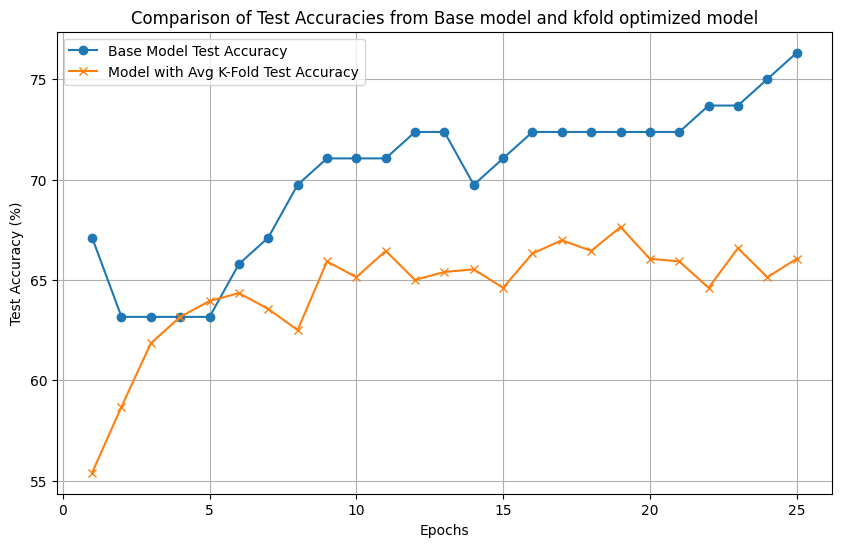

In [ ]:

plt.figure(figsize=(10,6))
plt.plot(range(1,25+1), te_a7, label='Base Model Test Accuracy', marker='o')
plt.plot(range(1,25+1), avg_e_accs, label='Model with Avg K-Fold Test Accuracy', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')
plt.title('Comparison of Test Accuracies from Base model and kfold optimized model')
plt.legend()
plt.grid(True)  # Adding a grid for better readability
plt.show()

Optimization - Learning rate scheduler

Epoch 1/25, T_L: 0.7137231466017271, V_L: 0.6917056679725647, Te_L: 0.6978569038604435, T_A: 37.171052631578945, V_A: 47.36842105263158, Te_A: 50.0
Epoch 2/25, T_L: 0.6807636053938615, V_L: 0.6519804835319519, Te_L: 0.679947020976167, T_A: 58.55263157894737, V_A: 68.42105263157895, Te_A: 63.1578947368421
Epoch 3/25, T_L: 0.6589796919571725, V_L: 0.6252643465995789, Te_L: 0.6689416319131851, T_A: 64.3092105263158, V_A: 68.42105263157895, Te_A: 63.1578947368421
Epoch 4/25, T_L: 0.6419684839876074, V_L: 0.6065150141716004, Te_L: 0.6609447814132038, T_A: 65.13157894736842, V_A: 68.42105263157895, Te_A: 63.1578947368421
Epoch 5/25, T_L: 0.6316346714371129, V_L: 0.5912142038345337, Te_L: 0.6537710777238795, T_A: 65.29605263157895, V_A: 68.42105263157895, Te_A: 63.1578947368421
Epoch 6/25, T_L: 0.6256215689997924, V_L: 0.5895620942115783, Te_L: 0.6531631240719243, T_A: 65.13157894736842, V_A: 68.42105263157895, Te_A: 63.1578947368421
Epoch 7/25, T_L: 0.6183648658426184, V_L: 0.587882995605468

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


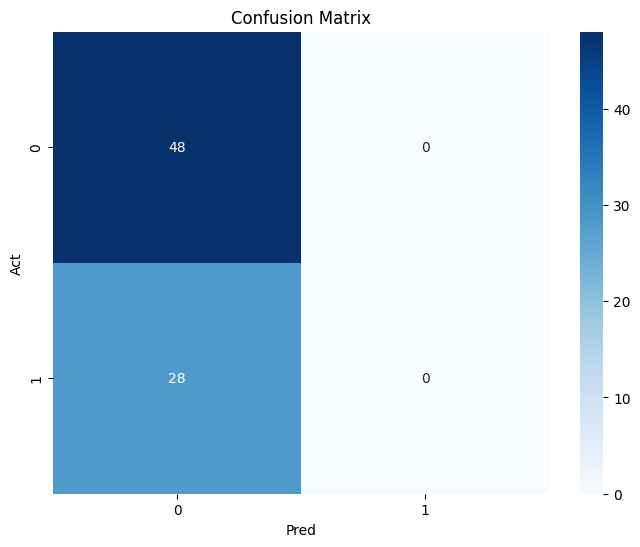

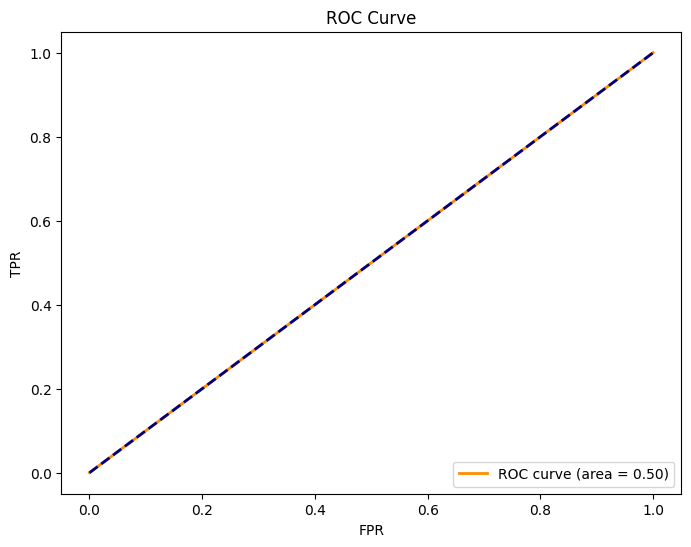

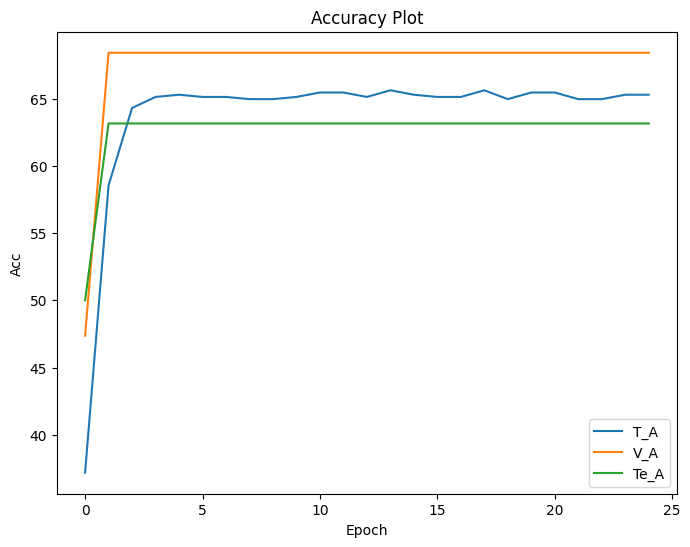

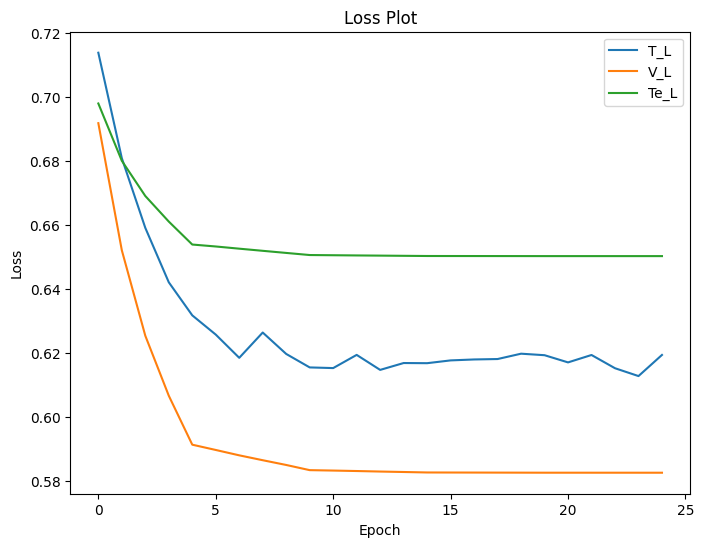

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time


class BC7(nn.Module):
    def __init__(self, dp=0.25, hl_size=64, activation_function=F.relu):
        super(BC7, self).__init__()
        self.l1=nn.Linear(7, hl_size)
        self.l2=nn.Linear(hl_size, 128)
        self.l3=nn.Linear(128, 1)
        self.dp=nn.Dropout(dp)
        self.activation_function=activation_function

    def forward(self, x):
        x=self.activation_function(self.l1(x))
        x=self.dp(x)
        x=self.activation_function(self.l2(x))
        x=self.dp(x)
        x=torch.sigmoid(self.l3(x))
        return x

# Instantiate the model
m_LR=BC7()

# Get model summary
from torchinfo import summary
ms=summary(m_LR, input_size=(1, 7))
ms

# Define loss function & optimizer
loss_fn=nn.BCELoss()
opt=SGD(m_LR.parameters(), lr=0.001, momentum=0.9)

# Add the learning rate scheduler
scheduler=lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)

# Training Loop with Validation and Test Loss
n_e=25
t_l_LR, v_l_LR, te_l_LR, t_a_LR, v_a_LR, te_a_LR=[], [], [], [], [], []
start_t=time.time()

for e in range(n_e):
    e_start_t=time.time()
    m_LR.train()
    b_l=[]
    c_t,t_t=0,0

    for i, l in train_dl:
        opt.zero_grad()
        o=m_LR(i)
        loss=loss_fn(o, l)
        loss.backward()
        opt.step()
        b_l.append(loss.item())

        # Accuracy
        pred=torch.round(o)
        t_t+=l.numel()
        c_t+=int((pred==l).sum())

    # Scheduler step for this epoch
    scheduler.step()

    t_l_LR.append(np.mean(b_l))
    t_a_LR.append(100 * c_t / t_t)

    # Validation
    m_LR.eval()
    b_v_l=[]
    c_v,t_v=0,0
    for i, l in val_dl:
        with torch.no_grad():
            o=m_LR(i)
            v_l_=loss_fn(o, l)
            b_v_l.append(v_l_.item())

            # Accuracy
            pred=torch.round(o)
            t_v+=l.numel()
            c_v+=int((pred==l).sum())

    v_l_LR.append(np.mean(b_v_l))
    v_a_LR.append(100 * c_v / t_v)

    # Test
    b_te_l, pred_e, act_e=[], [], []
    for i, l in test_dl:
        with torch.no_grad():
            o=m_LR(i)
            te_l_=loss_fn(o, l)
            b_te_l.append(te_l_.item())

            pred_val_e=torch.round(o)
            pred_e.extend(pred_val_e.numpy())
            act_e.extend(l.numpy())

    te_l_LR.append(np.mean(b_te_l))
    te_a_e=accuracy_score(act_e, pred_e)
    te_a_LR.append(te_a_e * 100)

    e_end_t=time.time()
    e_d=e_end_t-e_start_t
    print(f'Epoch {e+1}/{n_e}, T_L: {t_l_LR[-1]}, V_L: {v_l_LR[-1]}, Te_L: {te_l_LR[-1]}, T_A: {t_a_LR[-1]}, V_A: {v_a_LR[-1]}, Te_A: {te_a_LR[-1]}')

end_t=time.time()
tot_t=end_t-start_t
print(f'Total time: {tot_t:.2f}s ({tot_t/60:.2f}m)')

# Post-training eval
m_LR.eval()
preds, acts=[], []
with torch.no_grad():
    for i, l in test_dl:
        o=m_LR(i)
        preds_val=torch.round(o)
        preds.extend(preds_val.numpy())
        acts.extend(l.numpy())

acc = accuracy_score(acts, preds)
pr, re, f1, _=precision_recall_fscore_support(acts, preds, average='binary')
print(f'Acc: {acc}, Pr: {pr}, Re: {re}, F1: {f1}')

# Confusion Matrix
cfm=confusion_matrix(acts, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Act')
plt.xlabel('Pred')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _=roc_curve(acts, preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr,tpr,color='darkorange',lw=2,label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1],[0, 1],color='navy',lw=2,linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Accuracy plots
e_range=range(n_e)
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_a_LR,label='T_A')
plt.plot(e_range,v_a_LR,label='V_A')
plt.plot(e_range,te_a_LR,label='Te_A')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_l_LR,label='T_L')
plt.plot(e_range,v_l_LR,label='V_L')
plt.plot(e_range,te_l_LR,label='Te_L')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()


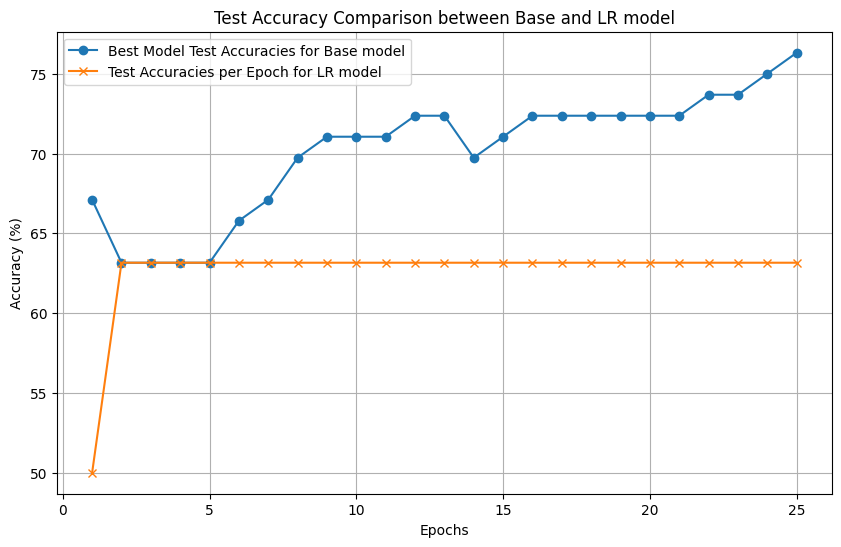

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,6))

    # Plotting the test accuracies from Code 1
plt.plot(range(1,25 +1),te_a7,label='Best Model Test Accuracies for Base model',marker='o')

    # Plotting the test accuracies from Code 4 for each epoch
plt.plot(range(1,25+1),te_a_LR,label='Test Accuracies per Epoch for LR model',marker='x')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Comparison between Base and LR model')
plt.legend()
plt.grid(True)
plt.show()

Optimization - Batch Normalization

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BatchBC7(nn.Module):
    def __init__(self, dropout=0.25, hidden_layer_size=64, activation_function=F.relu):
        super(BatchBC7, self).__init__()

        # Define the layers
        self.fc1=nn.Linear(7, hidden_layer_size)  #7 input features
        self.bn1=nn.BatchNorm1d(hidden_layer_size)  # BatchNorm for the first layer

        self.fc2=nn.Linear(hidden_layer_size, 128)
        self.bn2=nn.BatchNorm1d(128)  # BatchNorm for the second layer

        self.fc3=nn.Linear(128, 1)  # Output layer

        # Dropout and activation
        self.dropout=nn.Dropout(dropout)
        self.activation_function=activation_function

    def forward(self, x):
        # Apply first fully connected layer, followed by BatchNorm, an activation function, and then dropout
        x=self.fc1(x)
        x=self.bn1(x)
        x=self.activation_function(x)
        x=self.dropout(x)

        # Same for the second layer
        x=self.fc2(x)
        x=self.bn2(x)
        x=self.activation_function(x)
        x=self.dropout(x)

        # Output layer with sigmoid activation
        x=self.fc3(x)
        x=torch.sigmoid(x)
        return x


m_B=BatchBC7()
loss_fn=nn.BCELoss()
opt=SGD(m_B.parameters(), lr=0.001, momentum=0.9)

Epoch 1/25, T_L_B: 0.43704741291309657, V_L_B: 0.48873441815376284, Te_L_B: 0.5686846672983129, T_A_B: 79.9342105263158, V_A_B: 77.63157894736842, Te_A_B: 69.73684210526315
Epoch 2/25, T_L_B: 0.46996947103425074, V_L_B: 0.48724532723426817, Te_L_B: 0.5742280852159878, T_A_B: 78.94736842105263, V_A_B: 77.63157894736842, Te_A_B: 69.73684210526315
Epoch 3/25, T_L_B: 0.44392979537185867, V_L_B: 0.4874862998723984, Te_L_B: 0.5704100668295532, T_A_B: 78.28947368421052, V_A_B: 77.63157894736842, Te_A_B: 68.42105263157895
Epoch 4/25, T_L_B: 0.43548029621965006, V_L_B: 0.4915919929742813, Te_L_B: 0.5650071346868859, T_A_B: 79.4407894736842, V_A_B: 77.63157894736842, Te_A_B: 69.73684210526315
Epoch 5/25, T_L_B: 0.44298693302430603, V_L_B: 0.4891667693853378, Te_L_B: 0.5667356457193627, T_A_B: 79.11184210526316, V_A_B: 77.63157894736842, Te_A_B: 69.73684210526315
Epoch 6/25, T_L_B: 0.4515069448634198, V_L_B: 0.4906257212162018, Te_L_B: 0.5680887553117875, T_A_B: 76.64473684210526, V_A_B: 76.31578

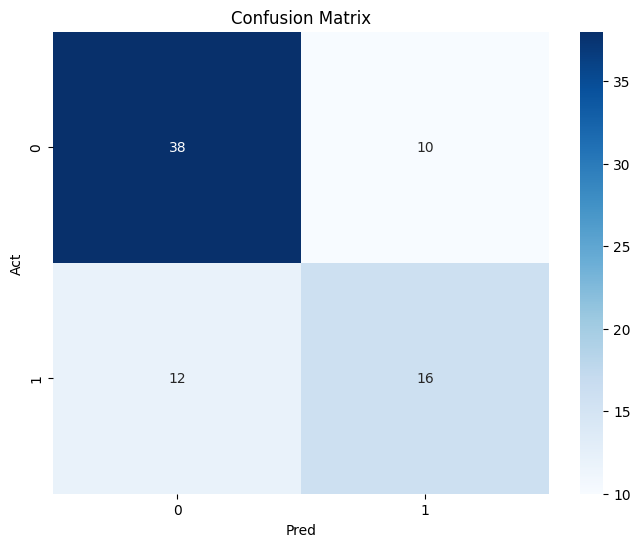

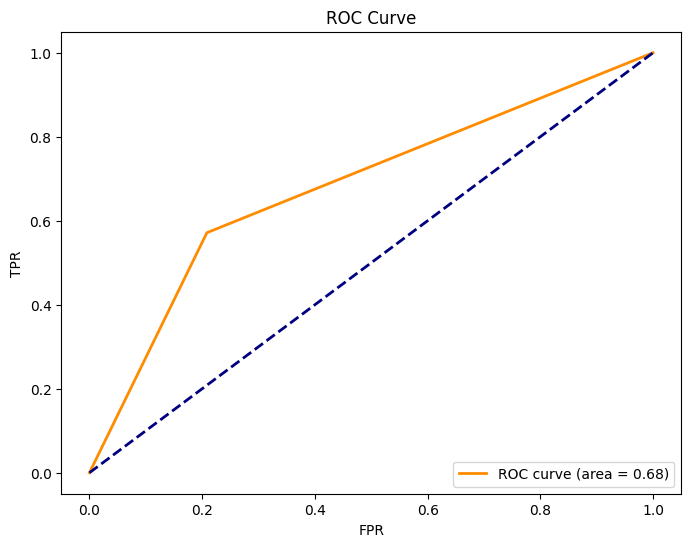

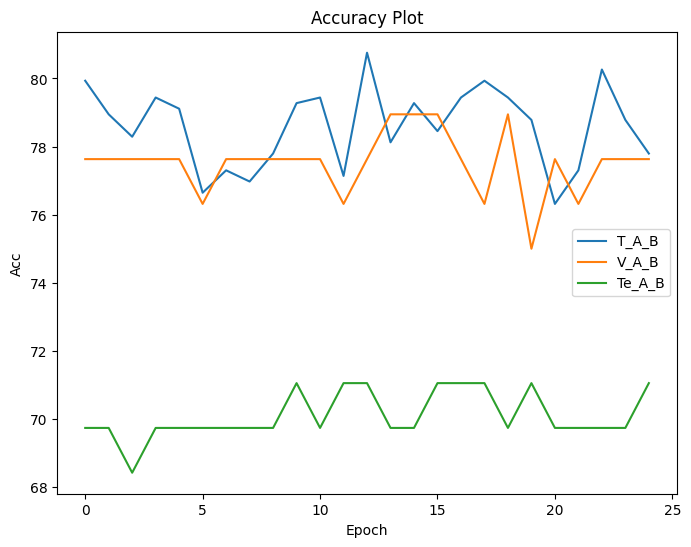

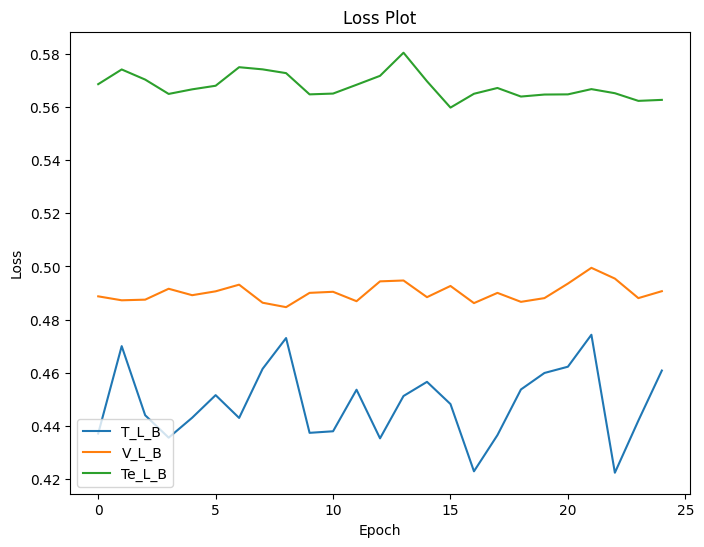

In [ ]:
# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
import seaborn as sns
import time

# Training Loop with Validation and Test Loss
n_e=25
t_l_B, v_l_B, te_l_B, t_a_B, v_a_B, te_a_B=[], [], [], [], [], []
start_t=time.time()

for e in range(n_e):
    e_start_t=time.time()
    m_B.train()
    b_l=[]
    c_t, t_t=0, 0

    for i, l in train_dl:
        opt.zero_grad()
        o=m_B(i)
        loss=loss_fn(o, l)
        loss.backward()
        opt.step()
        b_l.append(loss.item())

        # Accuracy
        pred=torch.round(o)
        t_t+=l.numel()
        c_t+=int((pred == l).sum())

    t_l_B.append(np.mean(b_l))
    t_a_B.append(100 * c_t / t_t)

    # Validation
    m_B.eval()
    b_v_l=[]
    c_v, t_v=0, 0
    for i, l in val_dl:
        with torch.no_grad():
            o=m_B(i)
            v_l_B_=loss_fn(o, l)
            b_v_l.append(v_l_B_.item())

            # Accuracy
            pred=torch.round(o)
            t_v+=l.numel()
            c_v+=int((pred == l).sum())

    v_l_B.append(np.mean(b_v_l))
    v_a_B.append(100 * c_v / t_v)

    # Test
    b_te_l, pred_e, act_e=[], [], []
    for i, l in test_dl:
        with torch.no_grad():
            o=m_B(i)
            te_l_B_=loss_fn(o, l)
            b_te_l.append(te_l_B_.item())

            pred_val_e=torch.round(o)
            pred_e.extend(pred_val_e.numpy())
            act_e.extend(l.numpy())

    te_l_B.append(np.mean(b_te_l))
    te_a_e=accuracy_score(act_e, pred_e)
    te_a_B.append(te_a_e * 100)

    e_end_t=time.time()
    e_d=e_end_t-e_start_t
    print(f'Epoch {e+1}/{n_e}, T_L_B: {t_l_B[-1]}, V_L_B: {v_l_B[-1]}, Te_L_B: {te_l_B[-1]}, T_A_B: {t_a_B[-1]}, V_A_B: {v_a_B[-1]}, Te_A_B: {te_a_B[-1]}')

end_t=time.time()
tot_t=end_t-start_t
print(f'Total time: {tot_t:.2f}s ({tot_t/60:.2f}m)')

# Post-training eval
m_B.eval()
preds, acts=[], []
with torch.no_grad():
    for i, l in test_dl:
        o=m_B(i)
        preds_val=torch.round(o)
        preds.extend(preds_val.numpy())
        acts.extend(l.numpy())

acc = accuracy_score(acts, preds)
pr, re, f1, _=precision_recall_fscore_support(acts, preds, average='binary')
print(f'Acc: {acc}, Pr: {pr}, Re: {re}, F1: {f1}')

# Confusion Matrix
cfm=confusion_matrix(acts, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cfm,annot=True,fmt="d",cmap="Blues")
plt.ylabel('Act')
plt.xlabel('Pred')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _=roc_curve(acts, preds)
roc_auc=auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr,color='darkorange',lw=2,label=f'ROC curve (area={roc_auc:.2f})')
plt.plot([0, 1],[0, 1], color='navy',lw=2,linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Accuracy plots
e_range=range(n_e)
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_a_B,label='T_A_B')
plt.plot(e_range,v_a_B,label='V_A_B')
plt.plot(e_range,te_a_B,label='Te_A_B')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

# Loss plots
plt.figure(figsize=(8, 6))
plt.plot(e_range,t_l_B,label='T_L_B')
plt.plot(e_range,v_l_B,label='V_L_B')
plt.plot(e_range,te_l_B,label='Te_L_B')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()


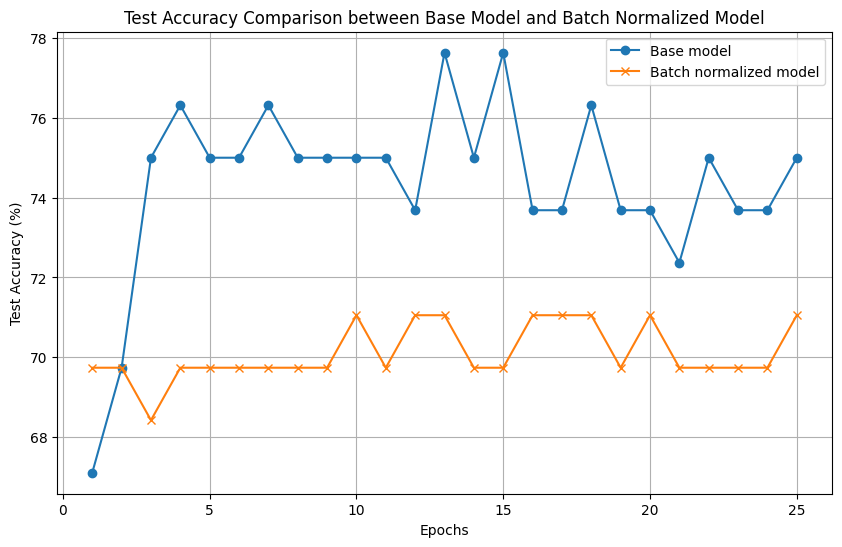

In [ ]:
import matplotlib.pyplot as plt

epochs=range(1,25+1)


plt.figure(figsize=(10, 6))
plt.plot(epochs,te_a,label='Base model',marker='o')
plt.plot(epochs,te_a_B,label='Batch normalized model',marker='x')

plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison between Base Model and Batch Normalized Model')
plt.legend()
plt.grid(True)
plt.show()
